# 🏛️ Legal Aid Navigator - Demo Notebook

This notebook demonstrates the Legal Aid Navigator system. The main implementation has been moved to modular Python files under the `src/` directory for better organization and maintainability.

## 📋 Project Overview

**Problem:** Tenants facing housing issues struggle to understand their legal rights and navigate complex housing laws that vary by location.

**Solution:** Advanced RAG system with multi-agent reasoning for complex queries and advanced retrieval techniques.

**Tech Stack:**
- **LLM:** GPT-4o
- **Embeddings:** text-embedding-3-small  
- **Vector DB:** Qdrant (in-memory)
- **Orchestration:** LangChain
- **Evaluation:** RAGAS
- **Monitoring:** LangSmith

## 🏗️ Project Structure

The code has been organized into task-wise modules:

```
📁 11_certification_challenge/
├── 📄 legal_aid_navigator.ipynb    # Main demo notebook
├── 📄 README.md                    # Project documentation
├── 📄 pyproject.toml               # Project dependencies
├── 📄 uv.lock                      # Lock file for dependencies
├── 📄 test_pdf_processing.py       # PDF processing tests
├── 📄 test_rag.html               # RAG testing interface
├── 📄 usecase_data_kg.json        # Use case data knowledge graph
├── 📄 rag_chain.joblib            # Saved RAG chain (joblib format)
├── 📄 rag_chain.pkl               # Saved RAG chain (pickle format)
│
├── 📁 src/                         # Source code modules
│   ├── 📄 __init__.py             # Package initialization
│   ├── 📄 data_ingestion.py       # Task 1: Data ingestion pipeline
│   ├── 📄 chunking_strategy.py    # Task 2: Document chunking strategy
│   └── 📄 dynamic_rag.py          # Dynamic RAG implementation
│
├── 📁 data/                        # Data directory
│   ├── 📁 raw/                     # Raw PDF documents
│   ├── 📁 processed/               # Processed documents
│   ├── 📁 vector_store/            # Vector database storage
│   └── 📁 golden_set/              # Golden dataset for evaluation
│
├── 📁 tests/                       # Test suite
│   ├── 📄 __init__.py             # Test package initialization
│   ├── 📄 test_retrieval.py       # Retrieval testing
│   └── 📁 golden_dataset/          # Golden dataset for testing
│
├── 📁 config/                      # Configuration files
├── 📁 frontend/                    # Frontend components
└── 📁 evaluation_results/          # Evaluation and metrics results
```

## 🚀 Quick Start

To run the complete system:
```bash
python src/main.py
```

Or import individual components:
```python
from src.rag_core import LegalRAGSystem
from src.multi_agent_system import LegalMultiAgentSystem
```


# 📑 Table of Contents

## 📋 Project Overview
- [Project Overview](#-project-overview)
- [Project Structure](#️-project-structure)
- [Quick Start](#-quick-start)

## 🚀 Core RAG Implementation
- [System Initialization](#-system-initialization)
- [Data Processing](#-data-processing)
- [Chunking](#-chunking)
- [Vector Embeddings](#-vector-embeddings)
- [Augmentation](#-augmentation)
- [Generation](#-generation)
- [Core RAG System Testing](#-core-rag-system-testing)

## 🤖 Advanced Features
- [Generating Synthetic Test Data](#-generating-synthetic-test-data)
- [LangSmith Dataset](#langsmith-dataset)
- [Dope-ifying Our Application](#dope-ifying-our-application)

## 📊 Evaluation & Performance
- [Evaluating the App with Ragas](#evaluating-the-app-with-ragas)
- [Making Adjustments and Re-Evaluating](#making-adjustments-and-re-evaluating)

---
**💡 Navigation Tip:** Use `Ctrl+F` (or `Cmd+F` on Mac) to quickly search for section headers!


In [2]:
# 🔧 Environment Setup and Imports
import os
import getpass
from pathlib import Path

# Import our modular components
from src.data_ingestion import LegalDocumentIngester
from src.chunking_strategy import LegalDocumentChunker

# LangChain imports
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

print("✅ All imports successful!")
print(f"📁 Working directory: {os.getcwd()}")


✅ Created 4 sample legal documents
📚 Loaded 4 legal documents
✅ All imports successful!
📁 Working directory: /home/swathi/AIProjects/AIE2/11_certification_challenge


In [3]:
# 🔑 API Key Setup
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
os.environ["COHERE_API_KEY"] = getpass.getpass("Enter your Cohere API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API Key:")

# Optional LangSmith setup
langsmith_key = getpass.getpass("Enter LangSmith API Key (optional, press Enter to skip): ")
if langsmith_key:
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_PROJECT"] = "Legal-Aid-Navigator-Demo"
    os.environ["LANGCHAIN_API_KEY"] = langsmith_key

print("✅ API keys configured!")


✅ API keys configured!


### 🚀 System Initialization

In [5]:
# Initialize all components
ingester = LegalDocumentIngester()
chunker = LegalDocumentChunker(chunk_size=1000, chunk_overlap=200)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Initialize tools for multi-agent system
tavily_tool = TavilySearchResults(max_results=5)
tool_belt = [tavily_tool, ArxivQueryRun()]
llm_with_tools = llm.bind_tools(tool_belt)

print("✅ System components initialized!")

✅ System components initialized!


/tmp/ipykernel_866/2879901649.py:9: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


### 🚀 Data Processing

In [6]:
# 📄 PDF Document Processing
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader

# Load PDF documents using LangChain DirectoryLoader
path = "data/raw/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader, show_progress=True)
pdf_docs = loader.load()

print(f"📄 Loaded {len(pdf_docs)} PDF pages")
print(f"📁 Sample document metadata: {pdf_docs[0].metadata if pdf_docs else 'No PDFs found'}")

# Use only PDF documents for now
all_documents = pdf_docs
print(f"\n✅ Using {len(all_documents)} PDF documents only")

100%|██████████| 5/5 [00:00<00:00, 13.87it/s]

📄 Loaded 6 PDF pages
📁 Sample document metadata: {'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-10-16T20:42:44-07:00', 'source': 'data/raw/Fair Housing Act Summary.pdf', 'file_path': 'data/raw/Fair Housing Act Summary.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': '', 'author': 'Kiran Eruva', 'subject': '', 'keywords': '', 'moddate': '2025-10-16T20:42:44-07:00', 'trapped': '', 'modDate': "D:20251016204244-07'00'", 'creationDate': "D:20251016204244-07'00'", 'page': 0}

✅ Using 6 PDF documents only


### 🚀 Chunking

Now we can chunk it down to size!

In [7]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200,
    length_function = tiktoken_len,
)

document_chunks = text_splitter.split_documents(all_documents)


Now we've successfully split our single PDF into 5 docs

In [8]:
len(document_chunks)

5

### 🚀 Vector Embeddings

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [9]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [10]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    documents=document_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Let's make sure we can access it as a retriever.

In [11]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### 🚀 Augmentation

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [13]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Set-up our RAG LCEL chain!

In [14]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [15]:
rag_chain.invoke({"question" : "My landlord in Los Angeles raised my rent by 12% this year. Is that legal under California law?"})

'No, it is not legal. Under California law, rent increases are capped at 5% plus the regional Consumer Price Index (CPI), with a maximum total increase of 10% per year. Since your landlord raised your rent by 12%, it exceeds the legal limit.'

### 🚀 Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [16]:
from langchain_openai import ChatOpenAI

generator_llm = ChatOpenAI(model="gpt-4.1-nano")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single graph - and we're off!

In [17]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

def retrieve(state: State):
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State):
  generator_chain = chat_prompt | generator_llm | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

rag_graph = StateGraph(State).add_sequence([retrieve, generate])
rag_graph.add_edge(START, "retrieve")
compiled_rag_graph = rag_graph.compile()

Let's test this out and make sure it works.

In [18]:
compiled_rag_graph.invoke({"question" : "My landlord in Los Angeles raised my rent by 12% this year. Is that legal under California law?"})

{'question': 'My landlord in Los Angeles raised my rent by 12% this year. Is that legal under California law?',
 'context': [Document(metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-10-16T20:44:26-07:00', 'source': 'data/raw/NOLO California Quick Guide.pdf', 'file_path': 'data/raw/NOLO California Quick Guide.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': '', 'author': 'Kiran Eruva', 'subject': '', 'keywords': '', 'moddate': '2025-10-16T20:44:26-07:00', 'trapped': '', 'modDate': "D:20251016204426-07'00'", 'creationDate': "D:20251016204426-07'00'", 'page': 0, '_id': '03c364c50cbe4efda563fbe3ef3c377b', '_collection_name': '553894ef4c2e4bef9a71bc2b1fecbeb1'}, page_content='NOLO California Quick Guide: Renters’ Rights \n© 2025 NOLO – Plain Language for Everyday Tenants \nThis guide cuts through the legal jargon to give California renters the practical knowledge they \nneed to protect themselves. \nRent i

In [ ]:
# # 🤖 Initialize RAG and Multi-Agent Systems
# # Get retriever for RAG system
# retriever = vector_store.get_retriever(search_kwargs={"k": 5})

# # Initialize RAG system
# rag_system = LegalRAGSystem(llm, retriever)

# # Initialize multi-agent system
# multi_agent_system = LegalMultiAgentSystem(llm_with_tools, retriever)

# # Initialize advanced retrieval system
# advanced_retrieval = AdvancedRetrievalSystem(vector_store.vectorstore, llm)

# # Initialize evaluator
# evaluator = LegalRAGEvaluator(rag_system, vector_store.vectorstore)

# print("✅ All systems initialized and ready!")

### 🤖 Core RAG System Testing


In [19]:
# Test the RAG system with sample questions
test_questions = [
    "What is the maximum rent increase allowed in San Francisco?",
    "What are my rights if my landlord won't fix mold in my apartment?",
    "What protected classes are covered under the Fair Housing Act?",
    "How much notice does a landlord have to give for eviction in Austin?"
]




### RAG Limitation
Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

In [22]:
import arxiv
from typing import List, Dict, Any
from langchain.schema import Document
from src.dynamic_rag import DynamicPaperFetcher
# In your notebook - replace hard-coded papers with dynamic fetching

# Initialize the dynamic fetcher
paper_fetcher = DynamicPaperFetcher(max_results=3)

# Example 1: Search by topic
legal_ai_papers = paper_fetcher.search_papers("legal AI OR legal technology OR legal automation")

# Example 2: Search by specific terms
rag_papers = paper_fetcher.search_papers("retrieval augmented generation legal")

# Example 3: Fetch specific paper by ID
specific_paper = paper_fetcher.fetch_paper_by_id("2301.00001")

# Combine with your existing PDF documents
all_documents = pdf_docs + legal_ai_papers + rag_papers

📄 Fetched 3 papers for query: 'legal AI OR legal technology OR legal automation'
📄 Fetched 3 papers for query: 'retrieval augmented generation legal'
📄 Fetched paper: NFTrig


### 🤖 Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

In [23]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [24]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [25]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in all_documents:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 12, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [26]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=all_documents, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/3 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/12 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/6 [00:00<?, ?it/s]

Property 'summary' already exists in node '15034a'. Skipping!
Property 'summary' already exists in node '131fc7'. Skipping!
Property 'summary' already exists in node 'a7b991'. Skipping!


Applying CustomNodeFilter: 0it [00:00, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/6 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '131fc7'. Skipping!
Property 'summary_embedding' already exists in node 'a7b991'. Skipping!
Property 'summary_embedding' already exists in node '15034a'. Skipping!


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 15, relationships: 15)

We can save and load our knowledge graphs as follows.

In [27]:
kg.save("usecase_data_kg.json")
usecase_data_kg = KnowledgeGraph.load("usecase_data_kg.json")
usecase_data_kg

KnowledgeGraph(nodes: 15, relationships: 15)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.


In [28]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=usecase_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [29]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        # (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]


Finally, we can use our `TestSetGenerator` to generate our testset!

In [30]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/5 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,discrimination law?,[Fair Housing Act Summary \nU.S. Department of...,The Fair Housing Act is a federal law that pro...,single_hop_specifc_query_synthesizer
1,Whaat are the tenants rights in Texas if the l...,[Texas Tenant Handbook \nIssued by the Texas S...,If your landlord raises your rent shortly afte...,single_hop_specifc_query_synthesizer
2,What are my rights regarding eviction under Ca...,[Prepared by the California Department of Cons...,"Under California law, evictions require 'just ...",single_hop_specifc_query_synthesizer
3,What resources are available to tenants in Tex...,[],The provided context does not include specific...,single_hop_specifc_query_synthesizer
4,"How does blockchain technology, such as blockL...",[\n Title: blockLAW: Blockchain...,"Blockchain technology, including blockLAW, off...",single_hop_specifc_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.

In [31]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(all_documents, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/3 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/12 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/6 [00:00<?, ?it/s]

Property 'summary' already exists in node '51e25b'. Skipping!
Property 'summary' already exists in node '9ea3f9'. Skipping!
Property 'summary' already exists in node 'ea834a'. Skipping!


Applying CustomNodeFilter: 0it [00:00, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/6 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'ea834a'. Skipping!
Property 'summary_embedding' already exists in node '51e25b'. Skipping!
Property 'summary_embedding' already exists in node '9ea3f9'. Skipping!


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples: 0it [00:00, ?it/s]

In [32]:
dataset.to_pandas()

""


## LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [34]:
from langsmith import Client

client = Client()

dataset_name = "legal_documents1"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Synthetic Data for Use Cases"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [35]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

In [36]:
rag_documents = all_documents

In [37]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [38]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [39]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG"
)

In [40]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [41]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [42]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [43]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [44]:
rag_chain.invoke({"question" : "What are tenant laws in california?"})

"California tenant laws provide strong protections for residential tenants, particularly in areas of rent control, habitability, eviction procedures, and retaliation safeguards:\n\n1. **Rent Control:**  \n   - Landlords may raise rent by no more than 5% plus the local Consumer Price Index (CPI), with a maximum total increase of 10% per year.  \n   - This applies to buildings over 15 years old, excluding single-family homes unless owned by corporations.  \n   - Local ordinances in cities like Los Angeles, San Francisco, and Oakland may have even stronger rent control protections.  \n   - The Tenant Protection Act of 2019 (AB 1482) enforces these limits statewide.\n\n2. **Habitability:**  \n   - Under Civil Code Section 1941, landlords must maintain rental units fit for human occupation.  \n   - Essential services such as heat, running water, electricity, and plumbing must function properly.  \n   - Units must be weatherproof, free from excessive mold or pests, and structurally sound.  \

### RAG Evaluation

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [45]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [46]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this response dope, lit, cool, or is it just a generic response?",
        },
        "llm" : eval_llm
    }
)

## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [47]:
DOPENESS_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Make your answer rad, ensure high levels of dopeness. Do not be generic, or give generic responses.

Context: {context}
Question: {question}
"""

dopeness_rag_prompt = ChatPromptTemplate.from_template(DOPENESS_RAG_PROMPT)

In [48]:
rag_documents = all_documents

Modifying our chunk size modify the performance of our application

In [49]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

In [50]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

Modifying our embedding model to modify the performance of our application

In [51]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG Docs"
)

In [52]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [53]:
dopeness_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dopeness_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [54]:
dopeness_rag_chain.invoke({"question" : "What are tenant laws in california?"})

'Yo, buckle up—let me drop some seriously rad knowledge on California tenant laws straight from the vault of 2025 wisdom. California’s got your back with fierce tenant protections, making sure your rental life is smooth and your digs are legit.\n\nFirst off, your crib *must* be habitable—this isn’t just a vibe, it’s the law (Civil Code Section 1941). We’re talking essentials like heat, running water, electricity, and plumbing all up and running. If your place turns into a moldy swamp or a pest party, or something breaks down, you gotta hit up your landlord in writing. They’ve got 30 days to fix it, but if it’s an urgent survival issue (no heat in winter, no water), they have to hustle harder and faster.\n\nSecurity deposits? Landlords can only grab up to two months’ rent if your spot’s unfurnished, or three months if it’s decked out with furniture. When you peace out, your landlord has 21 days max to return the full stash or break down deductions with receipts if repairs cost over $125

Finally, we can evaluate the new chain on the same test set!

In [55]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

In [56]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

### Building RAG Graph with LangGraph

Let's create some state for our LangGraph RAG graph!

In [57]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

Now we can build our simple graph!

> NOTE: We're using `add_sequence` since we will always move from retrieval to generation. This is essentially building a chain in LangGraph.

In [58]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [60]:
response = graph.invoke({"question" : "What are my rights if my landlord won't fix mold in my apartment?"})

In [61]:
response["response"]

"If your landlord won't fix mold in your apartment, you have the right to notify your landlord in writing about the issue. Under California law, your landlord is generally required to make repairs within 30 days, or sooner if the issue is urgent. If they fail to address the problem, you may have options such as requesting a pre-move-out inspection to document damage, or potentially withholding rent or repairing the issue and deducting the cost from your rent (though you should proceed carefully to avoid eviction risks). It's also important to document the mold and your communication with the landlord. If the problem persists or the landlord refuses to act, you can seek assistance from local legal aid organizations or tenant resources."

## Evaluating the App with Ragas

Now we can finally do our evaluation!

Step1: We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [62]:
import pandas as pd
from ragas import EvaluationDataset

# Load your golden dataset
golden_df = pd.read_csv('data/golden_set/questions.csv')

# Display the questions
print(f"📊 Loaded {len(golden_df)} questions from golden dataset")
print("\nSample questions:")
for i, row in golden_df.head(3).iterrows():
    print(f"  {row['question_id']}: {row['question_text']}")

📊 Loaded 20 questions from golden dataset

Sample questions:
  Q01: My landlord in Los Angeles raised my rent by 12% this year. Is that legal under California law?
  Q02: I live in a 10-year-old apartment in San Diego. Does the statewide rent cap apply to me?
  Q03: My landlord hasn’t fixed a mold problem for 6 weeks. What are my legal options in California?


Step2: 

Generate answers using your LCEL RAG chain


In [63]:
# Step 2: Generate answers using your LCEL RAG chain
def generate_rag_answers(questions_df, rag_chain):
    """
    Generate answers for all questions using your LCEL RAG chain
    """
    results = []
    
    for _, row in questions_df.iterrows():
        question_id = row['question_id']
        question_text = row['question_text']
        
        print(f"Processing {question_id}: {question_text[:50]}...")
        
        try:
            # Get answer from your LCEL RAG chain
            rag_result = rag_chain.invoke({"question": question_text})
            
            # Handle different possible output structures
            if isinstance(rag_result, dict):
                # Try different possible keys for the response
                answer = None
                contexts = []
                
                # Check for response in different possible keys
                if 'response' in rag_result:
                    answer = rag_result['response']
                elif 'answer' in rag_result:
                    answer = rag_result['answer']
                elif 'result' in rag_result:
                    answer = rag_result['result']
                else:
                    # If it's a string, use it directly
                    answer = str(rag_result)
                
                # Check for source documents in different possible keys
                if 'source_documents' in rag_result:
                    contexts = [doc.page_content for doc in rag_result['source_documents']]
                elif 'context' in rag_result:
                    contexts = [doc.page_content for doc in rag_result['context']]
                elif 'documents' in rag_result:
                    contexts = [doc.page_content for doc in rag_result['documents']]
                
                results.append({
                    'question_id': question_id,
                    'question': question_text,
                    'answer': answer,
                    'contexts': contexts,
                    'ground_truth': f"Answer for {question_id}"
                })
            else:
                # If rag_result is not a dict, treat it as the answer
                results.append({
                    'question_id': question_id,
                    'question': question_text,
                    'answer': str(rag_result),
                    'contexts': [],
                    'ground_truth': f"Answer for {question_id}"
                })
                
        except Exception as e:
            print(f"❌ Error processing {question_id}: {e}")
            # Add empty result to maintain structure
            results.append({
                'question_id': question_id,
                'question': question_text,
                'answer': f"Error: {str(e)}",
                'contexts': [],
                'ground_truth': f"Answer for {question_id}"
            })
    
    return results

# Generate answers using your LCEL RAG chain
print("🤖 Generating answers using LCEL RAG chain...")
rag_results = generate_rag_answers(golden_df, rag_chain)
print(f"✅ Generated {len(rag_results)} answers")

🤖 Generating answers using LCEL RAG chain...
Processing Q01: My landlord in Los Angeles raised my rent by 12% t...
Processing Q02: I live in a 10-year-old apartment in San Diego. Do...
Processing Q03: My landlord hasn’t fixed a mold problem for 6 week...
Processing Q04: Can my landlord in Oakland evict me just because m...
Processing Q05: How long does my landlord have to return my securi...
Processing Q06: My landlord in Houston shut off my electricity bec...
Processing Q07: I’ve lived in my Dallas apartment for 8 months. Ho...
Processing Q08: My AC broke in July in Austin,  and my landlord ha...
Processing Q09: Can a landlord in Texas charge a $3, 000 security ...
Processing Q10: I received a 3-day notice to vacate in Fort Worth ...
Processing Q11: My landlord refused to rent to me because I have t...
Processing Q12: I use a wheelchair and need to install grab bars i...
Processing Q13: Is it legal for a rental ad to say 'perfect for yo...
Processing Q14: My landlord says emotional su

Step3:
Load and Use Your Ground Truth Dataset

In [64]:
from langsmith import Client
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    ResponseRelevancy
)
from datasets import Dataset
import numpy as np

# Initialize LangSmith client for tracking
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Advanced_Retrieval_Evaluation"
client = Client()

In [65]:
# Step 3: Load your ground truth answers
import pandas as pd

# Load your ground truth answers
ground_truth_df = pd.read_csv('data/golden_set/ground_truth_answers.csv')

print(f"📊 Loaded {len(ground_truth_df)} ground truth answers")
print("\nSample ground truth data:")
print(ground_truth_df.head(3))

# Create a mapping for easy lookup
ground_truth_map = dict(zip(ground_truth_df['question_id'], ground_truth_df['answer']))
reference_context_map = dict(zip(ground_truth_df['question_id'], ground_truth_df['reference_context']))

print(f"\n✅ Created ground truth mapping for {len(ground_truth_map)} questions")

📊 Loaded 20 ground truth answers

Sample ground truth data:
  question_id                                             answer  \
0         Q01  No, a 12% rent increase exceeds California’s s...   
1         Q02  No. The statewide rent cap under AB 1482 only ...   
2         Q03  You have several options. First, you must have...   

                                   reference_context  
0  Rent increases are limited under the Tenant Pr...  
1  This law applies to buildings over 15 years ol...  
2  If something breaks or becomes unsafe, you mus...  

✅ Created ground truth mapping for 20 questions


 Step 4: 
 
 Merge RAG Results with Ground Truth

In [66]:
# Step 4: Merge your RAG results with ground truth
def merge_with_ground_truth(rag_results, ground_truth_map, reference_context_map):
    """
    Merge RAG results with ground truth answers
    """
    enhanced_results = []
    
    for result in rag_results:
        question_id = result['question_id']
        
        # Get ground truth and reference context
        ground_truth = ground_truth_map.get(question_id, "No ground truth available")
        reference_context = reference_context_map.get(question_id, "No reference context")
        
        enhanced_result = {
            'question_id': question_id,
            'question': result['question'],
            'answer': result['answer'],  # RAG-generated answer
            'ground_truth_answer': ground_truth,  # Ground truth from CSV
            'contexts': result['contexts'],  # Retrieved contexts from RAG
            'reference_context': reference_context  # Reference context from CSV
        }
        
        enhanced_results.append(enhanced_result)
    
    return enhanced_results

# Merge results with ground truth
print("🔗 Merging RAG results with ground truth...")
enhanced_results = merge_with_ground_truth(rag_results, ground_truth_map, reference_context_map)
print(f"✅ Enhanced {len(enhanced_results)} results with ground truth")

🔗 Merging RAG results with ground truth...
✅ Enhanced 20 results with ground truth


Step 5: 

Create RAGAS Evaluation Dataset

In [67]:
# Step 5: Create RAGAS evaluation dataset (FIXED VERSION)
from ragas import EvaluationDataset

# Convert to RAGAS format
evaluation_data = []

for result in enhanced_results:
    evaluation_data.append({
        'user_input': result['question'],
        'response': result['answer'],
        'retrieved_contexts': result['contexts'],
        'reference': result['ground_truth_answer']  # Fixed: use 'ground_truth_answer' from your dict
    })

# Create RAGAS dataset
dataset = EvaluationDataset.from_list(evaluation_data)
print(f"✅ Created RAGAS dataset with {len(dataset.samples)} samples")

# Verify the dataset
print(f"\n📋 Dataset verification:")
print(f"  Questions: {len(dataset.samples)}")

# Use correct RAGAS attribute names
sample = dataset.samples[0]
print(f"  Sample question: {sample.user_input}")
print(f"  Sample ground truth: {sample.reference[:100]}...")
print(f"  Sample answer: {sample.response[:100]}...")
print(f"  Sample contexts: {len(sample.retrieved_contexts)} contexts")

✅ Created RAGAS dataset with 20 samples

📋 Dataset verification:
  Questions: 20
  Sample question: My landlord in Los Angeles raised my rent by 12% this year. Is that legal under California law?
  Sample ground truth: No, a 12% rent increase exceeds California’s statewide rent cap. Under the Tenant Protection Act of ...
  Sample answer: No, that is not legal under California law. Rent increases are capped statewide at 5% plus the local...
  Sample contexts: 0 contexts


Step 6: 

Run RAGAS Evaluation

In [68]:
# Step 6: Run RAGAS evaluation
from ragas.metrics import (
    LLMContextRecall, 
    Faithfulness, 
    FactualCorrectness, 
    ResponseRelevancy
)
from ragas import evaluate, RunConfig

# Set up evaluation
custom_run_config = RunConfig(timeout=360)

# Define metrics
metrics = [
    LLMContextRecall(),
    Faithfulness(),
    FactualCorrectness(),
    ResponseRelevancy()
]

# Run evaluation
print("🔍 Running RAGAS evaluation...")
try:
    result = evaluate(
        dataset=dataset,
        metrics=metrics,
        llm=llm,
        embeddings=embeddings,
        run_config=custom_run_config
    )
    
    print("✅ Evaluation completed successfully!")
    print("\n📊 Results:")
    print(result)
    
except Exception as e:
    print(f"❌ Evaluation failed: {e}")
    print("This might be due to:")
    print("  • Empty dataset")
    print("  • Missing required columns")
    print("  • API issues")

🔍 Running RAGAS evaluation...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

✅ Evaluation completed successfully!

📊 Results:
{'context_recall': 1.0000, 'faithfulness': 0.3530, 'factual_correctness': 0.7320, 'answer_relevancy': 0.7538}


## Making Adjustments and Re-Evaluating

Now that we've got our baseline - let's make a change and see how the model improves or doesn't improve!

> NOTE: This will be using Cohere's Rerank model - please be sure to [sign-up for an API key!](https://docs.cohere.com/reference/about)

In [69]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Enter your Cohere API Key:")


ADVANCED RETRIEVAL WITH COHERE RERANKING - COMPLETE EVALUATION

📦 Step 1: Creating improved vector store with smaller chunks...
✂️ Created 14 smaller chunks (vs 5 original)
🔄 Using improved embedding model: text-embedding-3-large
✅ Improved vector store created

🔄 Step 2: Setting up Cohere reranking pipeline...
📊 Base retriever: fetching top 20 documents
🎯 Reranker: selecting top 5 from 20 candidates
✅ Reranking retriever configured

🔗 Step 3: Building reranked RAG chain...
✅ Reranked RAG chain created

🧪 Testing reranked chain...
✅ Test successful!
📝 Sample response: I don't know...

Step 4: GENERATING ANSWERS WITH RERANKED SYSTEM
🤖 Generating answers for 20 questions...
⏱️ Estimated time: ~0.7 minutes

[1/20] Q01: My landlord in Los Angeles raised my rent by 12% this year. ...
           ✅ Generated (12 chars)
[2/20] Q02: I live in a 10-year-old apartment in San Diego. Does the sta...
           ✅ Generated (130 chars)
[3/20] Q03: My landlord hasn’t fixed a mold problem for 6 weeks.

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Exception raised in Job[32]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8gI3RNnTX925NT8mBbHwiOnW on tokens per min (TPM): Limit 30000, Used 29975, Requested 986. Please try again in 1.921s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[34]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8gI3RNnTX925NT8mBbHwiOnW on tokens per min (TPM): Limit 30000, Used 29199, Requested 927. Please try again in 251ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[10]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8gI3RNnTX925NT8mBbHwiOnW on tokens per min (TPM): Limit 30000, Used 30000, Requeste


✅ Reranked system evaluation completed!

📊 RERANKED SYSTEM RESULTS
{'context_recall': 0.0000, 'faithfulness': 0.0000, 'factual_correctness': 0.1124, 'answer_relevancy': 0.2509}

📈 Summary Statistics:
       context_recall  faithfulness  factual_correctness  answer_relevancy
count            19.0          20.0            17.000000         20.000000
mean              0.0           0.0             0.112353          0.250941
std               0.0           0.0             0.258349          0.385460
min               0.0           0.0             0.000000          0.000000
25%               0.0           0.0             0.000000          0.000000
50%               0.0           0.0             0.000000          0.059626
75%               0.0           0.0             0.000000          0.265268
max               0.0           0.0             0.800000          0.983188

📊 Mean Scores:
❌ Reranked evaluation failed: Could not convert ["My landlord in Los Angeles raised my rent by 12% this year

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Exception raised in Job[2]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8gI3RNnTX925NT8mBbHwiOnW on tokens per min (TPM): Limit 30000, Used 29692, Requested 1054. Please try again in 1.492s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[16]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8gI3RNnTX925NT8mBbHwiOnW on tokens per min (TPM): Limit 30000, Used 30000, Requested 989. Please try again in 1.978s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[10]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8gI3RNnTX925NT8mBbHwiOnW on tokens per min (TPM): Limit 30000, Used 29974, Request

✅ Baseline evaluation completed
❌ Comparison failed: Could not convert ["My landlord in Los Angeles raised my rent by 12% this year. Is that legal under California law?I live in a 10-year-old apartment in San Diego. Does the statewide rent cap apply to me?My landlord hasn’t fixed a mold problem for 6 weeks. What are my legal options in California?Can my landlord in Oakland evict me just because my one-year lease ended?How long does my landlord have to return my security deposit after I move out in California?My landlord in Houston shut off my electricity because I was 5 days late on rent. Is that allowed in Texas?I’ve lived in my Dallas apartment for 8 months. How much notice does my landlord need to give me for a rent increase?My AC broke in July in Austin,  and my landlord hasn’t fixed it in 10 days. What can I do under Texas law?Can a landlord in Texas charge a $3, 000 security deposit for a $1, 200/month apartment?I received a 3-day notice to vacate in Fort Worth for late rent. Wha

Traceback (most recent call last):
  File "/tmp/ipykernel_866/1283841376.py", line 284, in <module>
    baseline_scores = baseline_evaluation_result.to_pandas().mean()
  File "/home/swathi/AIProjects/AIE2/11_certification_challenge/.venv/lib/python3.13/site-packages/pandas/core/frame.py", line 11720, in mean
    result = super().mean(axis, skipna, numeric_only, **kwargs)
  File "/home/swathi/AIProjects/AIE2/11_certification_challenge/.venv/lib/python3.13/site-packages/pandas/core/generic.py", line 12485, in mean
    return self._stat_function(
           ~~~~~~~~~~~~~~~~~~~^
        "mean", nanops.nanmean, axis, skipna, numeric_only, **kwargs
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/swathi/AIProjects/AIE2/11_certification_challenge/.venv/lib/python3.13/site-packages/pandas/core/generic.py", line 12442, in _stat_function
    return self._reduce(
           ~~~~~~~~~~~~^
        func, name=name, axis=axis, skipna=skipna, numeric_only=

⚠️ Could not create visualizations: name 'comparison_df' is not defined

Step 9: SAVING RESULTS
✅ Saved: evaluation_results/reranked_results.csv
✅ Saved: evaluation_results/reranked_metrics.csv
✅ Saved: evaluation_results/baseline_results.csv

📂 All results saved to 'evaluation_results/' directory

Step 10: SAMPLE ANSWER COMPARISONS

QUESTION 1: My landlord in Los Angeles raised my rent by 12% this year. Is that legal under California law?

📘 GROUND TRUTH:
No, a 12% rent increase exceeds California’s statewide rent cap. Under the Tenant Protection Act of 2019 (AB 1482), landlords may increase rent by no more than 5% plus the local Consumer Price Index (CPI), with a maximum total increase of 10% per year. This applies to most rental units over 15 years old, including those in Los Angeles.

📗 BASELINE ANSWER (346 chars):
No, that is not legal under California law. Rent increases are capped statewide at 5% plus the local Consumer Price Index (CPI), with a maximum total increase of 10% per

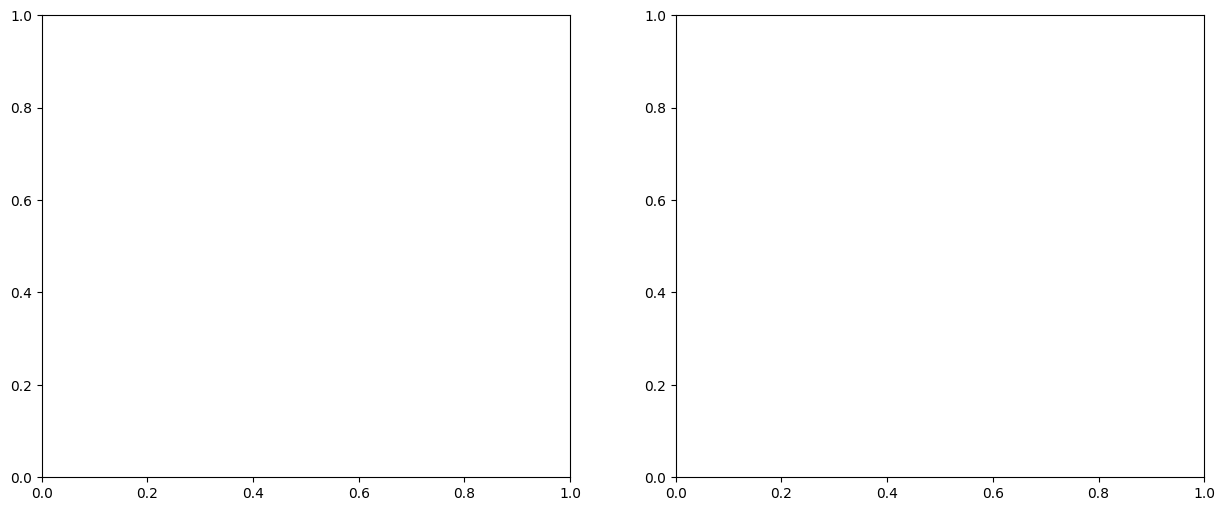

In [70]:
# =============================================================================
# COMPLETE RE-EVALUATION WITH COHERE RERANKING
# Add this section to your notebook after the basic RAG evaluation
# =============================================================================

# %% Cell: Setup for Reranking Evaluation
print("\n" + "="*80)
print("ADVANCED RETRIEVAL WITH COHERE RERANKING - COMPLETE EVALUATION")
print("="*80)

# Import required libraries (if not already imported)
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Qdrant
import time
import pandas as pd
from ragas import evaluate, EvaluationDataset, RunConfig
from ragas.metrics import (
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    ResponseRelevancy
)

# %% Cell: Create Improved Vector Store
print("\n📦 Step 1: Creating improved vector store with smaller chunks...")

# Create smaller chunks for better precision
improved_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    length_function=tiktoken_len
)

improved_chunks = improved_text_splitter.split_documents(all_documents)
print(f"✂️ Created {len(improved_chunks)} smaller chunks (vs {len(document_chunks)} original)")

# Use better embeddings
improved_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
print(f"🔄 Using improved embedding model: text-embedding-3-large")

# Create new vector store
improved_vectorstore = Qdrant.from_documents(
    documents=improved_chunks,
    embedding=improved_embeddings,
    location=":memory:",
    collection_name="legal_aid_rag_improved"
)

print("✅ Improved vector store created")

# %% Cell: Setup Cohere Reranking
print("\n🔄 Step 2: Setting up Cohere reranking pipeline...")

# Base retriever with higher k to get more candidates
base_retriever_rerank = improved_vectorstore.as_retriever(search_kwargs={"k": 20})
print(f"📊 Base retriever: fetching top 20 documents")

# Cohere reranker
compressor = CohereRerank(model="rerank-v3.5", top_n=5)
print(f"🎯 Reranker: selecting top 5 from 20 candidates")

# Contextual compression retriever
rerank_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=base_retriever_rerank
)

print("✅ Reranking retriever configured")

# %% Cell: Build Reranked RAG Chain
print("\n🔗 Step 3: Building reranked RAG chain...")

from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

reranked_rag_chain = (
    {"context": itemgetter("question") | rerank_retriever, "question": itemgetter("question")}
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

print("✅ Reranked RAG chain created")

# Test the reranked chain
print("\n🧪 Testing reranked chain...")
test_question = "My landlord in Los Angeles raised my rent by 12% this year. Is that legal under California law?"
try:
    reranked_test_response = reranked_rag_chain.invoke({"question": test_question})
    print(f"✅ Test successful!")
    print(f"📝 Sample response: {reranked_test_response[:200]}...")
except Exception as e:
    print(f"❌ Test failed: {e}")

# %% Cell: Generate Answers with Reranked System
print("\n" + "="*80)
print("Step 4: GENERATING ANSWERS WITH RERANKED SYSTEM")
print("="*80)

def generate_reranked_answers(questions_df, reranked_chain, delay=2):
    """
    Generate answers using reranked retrieval system
    """
    results = []
    total = len(questions_df)
    
    print(f"🤖 Generating answers for {total} questions...")
    print(f"⏱️ Estimated time: ~{total * delay / 60:.1f} minutes\n")
    
    for idx, row in questions_df.iterrows():
        question_id = row['question_id']
        question_text = row['question_text']
        
        print(f"[{idx+1}/{total}] {question_id}: {question_text[:60]}...")
        
        try:
            # Invoke the reranked RAG chain
            answer = reranked_chain.invoke({"question": question_text})
            
            results.append({
                'question_id': question_id,
                'question': question_text,
                'answer': answer,
                'contexts': [],
            })
            
            print(f"           ✅ Generated ({len(answer)} chars)")
            
            # Delay to avoid rate limiting
            time.sleep(delay)
            
        except Exception as e:
            print(f"           ❌ Error: {str(e)[:50]}...")
            results.append({
                'question_id': question_id,
                'question': question_text,
                'answer': f"Error: {str(e)}",
                'contexts': [],
            })
    
    return results

# Generate answers
reranked_results = generate_reranked_answers(golden_df, reranked_rag_chain, delay=2)
print(f"\n✅ Generated {len(reranked_results)} reranked answers")

# %% Cell: Merge with Ground Truth
print("\n🔗 Step 5: Merging reranked results with ground truth...")

ground_truth_map = dict(zip(ground_truth_df['question_id'], ground_truth_df['answer']))

enhanced_reranked_results = []
for result in reranked_results:
    question_id = result['question_id']
    
    enhanced_result = {
        'question_id': question_id,
        'question': result['question'],
        'answer': result['answer'],
        'ground_truth_answer': ground_truth_map.get(question_id, "No ground truth"),
        'contexts': result.get('contexts', [])
    }
    
    enhanced_reranked_results.append(enhanced_result)

print(f"✅ Enhanced {len(enhanced_reranked_results)} results with ground truth")

# Display sample
print("\n📋 Sample Enhanced Result:")
sample = enhanced_reranked_results[0]
print(f"  Question: {sample['question'][:60]}...")
print(f"  Answer length: {len(sample['answer'])} chars")
print(f"  Has ground truth: {len(sample['ground_truth_answer']) > 20}")

# %% Cell: Create RAGAS Evaluation Dataset
print("\n" + "="*80)
print("Step 6: CREATING RAGAS EVALUATION DATASET")
print("="*80)

reranked_evaluation_data = [
    {
        'user_input': result['question'],
        'response': result['answer'],
        'retrieved_contexts': result.get('contexts', []),
        'reference': result['ground_truth_answer']
    }
    for result in enhanced_reranked_results
]

reranked_evaluation_dataset = EvaluationDataset.from_list(reranked_evaluation_data)
print(f"✅ Created reranked evaluation dataset with {len(reranked_evaluation_dataset.samples)} samples")

# Verify dataset
sample = reranked_evaluation_dataset.samples[0]
print(f"\n📋 Dataset Verification:")
print(f"  User input: {sample.user_input[:60]}...")
print(f"  Response: {sample.response[:60]}...")
print(f"  Reference: {sample.reference[:60]}...")
print(f"  Contexts: {len(sample.retrieved_contexts)} items")

# %% Cell: Run RAGAS Evaluation on Reranked System
print("\n" + "="*80)
print("Step 7: EVALUATING RERANKED SYSTEM WITH RAGAS")
print("="*80)

reranked_metrics = [
    LLMContextRecall(),
    Faithfulness(),
    FactualCorrectness(),
    ResponseRelevancy()
]

print("🔍 Running RAGAS evaluation on reranked system...")
print("⏱️ This may take several minutes...\n")

try:
    reranked_evaluation_result = evaluate(
        dataset=reranked_evaluation_dataset,
        metrics=reranked_metrics,
        llm=eval_llm,
        embeddings=improved_embeddings,
        run_config=custom_run_config
    )
    
    print("\n✅ Reranked system evaluation completed!")
    print("\n" + "="*80)
    print("📊 RERANKED SYSTEM RESULTS")
    print("="*80)
    print(reranked_evaluation_result)
    
    # Convert to DataFrame
    reranked_results_df = reranked_evaluation_result.to_pandas()
    print("\n📈 Summary Statistics:")
    print(reranked_results_df.describe())
    
    print("\n📊 Mean Scores:")
    print(reranked_results_df.mean())
    
except Exception as e:
    print(f"❌ Reranked evaluation failed: {e}")
    print("\n🔧 Troubleshooting:")
    print("  • Check if dataset has all required columns")
    print("  • Verify API keys are valid and have credits")
    print("  • Check rate limits")
    print("  • Ensure ground truth answers exist")

# %% Cell: Compare Baseline vs Reranked
print("\n" + "="*80)
print("Step 8: PERFORMANCE COMPARISON - BASELINE vs RERANKED")
print("="*80)

try:
    # Get baseline scores (assuming you already ran baseline evaluation)
    # If not, run it first:
    if 'baseline_evaluation_result' not in locals():
        print("📊 Baseline evaluation not found. Running now...")
        
        baseline_evaluation_data = [
            {
                'user_input': result['question'],
                'response': result['answer'],
                'retrieved_contexts': result.get('contexts', []),
                'reference': result['ground_truth_answer']
            }
            for result in enhanced_results
        ]
        
        baseline_evaluation_dataset = EvaluationDataset.from_list(baseline_evaluation_data)
        
        baseline_evaluation_result = evaluate(
            dataset=baseline_evaluation_dataset,
            metrics=reranked_metrics,
            llm=eval_llm,
            embeddings=embedding_model,
            run_config=custom_run_config
        )
        
        print("✅ Baseline evaluation completed")
    
    # Create comparison
    baseline_scores = baseline_evaluation_result.to_pandas().mean()
    reranked_scores = reranked_evaluation_result.to_pandas().mean()
    
    comparison_df = pd.DataFrame({
        'Baseline': baseline_scores,
        'Reranked': reranked_scores,
        'Improvement': reranked_scores - baseline_scores,
        'Improvement %': ((reranked_scores - baseline_scores) / baseline_scores * 100).round(2)
    })
    
    print("\n" + "="*80)
    print("📊 BASELINE vs RERANKED COMPARISON")
    print("="*80)
    print(comparison_df.to_string())
    
    # Analyze improvements
    print("\n" + "="*80)
    print("🎯 KEY INSIGHTS")
    print("="*80)
    
    for metric in comparison_df.index:
        improvement = comparison_df.loc[metric, 'Improvement %']
        baseline_val = comparison_df.loc[metric, 'Baseline']
        reranked_val = comparison_df.loc[metric, 'Reranked']
        
        if improvement > 5:
            print(f"✅ {metric}:")
            print(f"   Baseline: {baseline_val:.3f} → Reranked: {reranked_val:.3f}")
            print(f"   SIGNIFICANT IMPROVEMENT (+{improvement:.1f}%)")
        elif improvement > 0:
            print(f"📈 {metric}:")
            print(f"   Baseline: {baseline_val:.3f} → Reranked: {reranked_val:.3f}")
            print(f"   Slight improvement (+{improvement:.1f}%)")
        elif improvement < -5:
            print(f"❌ {metric}:")
            print(f"   Baseline: {baseline_val:.3f} → Reranked: {reranked_val:.3f}")
            print(f"   Significant decrease ({improvement:.1f}%)")
        else:
            print(f"➡️ {metric}:")
            print(f"   Baseline: {baseline_val:.3f} → Reranked: {reranked_val:.3f}")
            print(f"   Minimal change ({improvement:.1f}%)")
    
    # Overall assessment
    avg_improvement = comparison_df['Improvement %'].mean()
    print(f"\n{'='*80}")
    print(f"📊 OVERALL AVERAGE IMPROVEMENT: {avg_improvement:.2f}%")
    print(f"{'='*80}")
    
    if avg_improvement > 5:
        print("🎉 CONCLUSION: Reranking provides SIGNIFICANT performance boost!")
        print("   Recommendation: Use reranking in production")
    elif avg_improvement > 0:
        print("✅ CONCLUSION: Reranking shows positive improvement")
        print("   Recommendation: Consider reranking, monitor costs")
    else:
        print("⚠️ CONCLUSION: Reranking did not improve performance significantly")
        print("   Recommendation: Stick with baseline, investigate why")
    
except Exception as e:
    print(f"❌ Comparison failed: {e}")
    import traceback
    traceback.print_exc()

# %% Cell: Visualize Comparison
print("\n📊 Creating comparison visualizations...")

try:
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart comparison
    x = np.arange(len(comparison_df.index))
    width = 0.35
    
    ax1.bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', color='skyblue')
    ax1.bar(x + width/2, comparison_df['Reranked'], width, label='Reranked', color='orange')
    
    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('Baseline vs Reranked Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.replace('_', ' ').title() for m in comparison_df.index], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Improvement percentage chart
    colors = ['green' if x > 0 else 'red' for x in comparison_df['Improvement %']]
    ax2.barh(comparison_df.index, comparison_df['Improvement %'], color=colors, alpha=0.7)
    ax2.set_xlabel('Improvement %')
    ax2.set_title('Performance Improvement')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(comparison_df['Improvement %']):
        ax2.text(v, i, f' {v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.savefig('evaluation_results/baseline_vs_reranked_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved visualization: evaluation_results/baseline_vs_reranked_comparison.png")
    plt.show()
    
except Exception as e:
    print(f"⚠️ Could not create visualizations: {e}")

# %% Cell: Save All Results
print("\n" + "="*80)
print("Step 9: SAVING RESULTS")
print("="*80)

try:
    # Create results directory if it doesn't exist
    import os
    os.makedirs('evaluation_results', exist_ok=True)
    
    # Save reranked results
    reranked_results_df = pd.DataFrame(enhanced_reranked_results)
    reranked_results_df.to_csv('evaluation_results/reranked_results.csv', index=False)
    print("✅ Saved: evaluation_results/reranked_results.csv")
    
    # Save reranked metrics
    if 'reranked_evaluation_result' in locals():
        reranked_evaluation_result.to_pandas().to_csv(
            'evaluation_results/reranked_metrics.csv',
            index=False
        )
        print("✅ Saved: evaluation_results/reranked_metrics.csv")
    
    # Save comparison
    if 'comparison_df' in locals():
        comparison_df.to_csv('evaluation_results/baseline_vs_reranked_comparison.csv')
        print("✅ Saved: evaluation_results/baseline_vs_reranked_comparison.csv")
    
    # Save baseline results (if not already saved)
    if 'enhanced_results' in locals():
        baseline_results_df = pd.DataFrame(enhanced_results)
        baseline_results_df.to_csv('evaluation_results/baseline_results.csv', index=False)
        print("✅ Saved: evaluation_results/baseline_results.csv")
    
    print(f"\n📂 All results saved to 'evaluation_results/' directory")
    
except Exception as e:
    print(f"⚠️ Could not save some results: {e}")

# %% Cell: Sample Answer Comparisons
print("\n" + "="*80)
print("Step 10: SAMPLE ANSWER COMPARISONS")
print("="*80)

# Show side-by-side comparison for first 3 questions
num_samples = min(3, len(enhanced_results), len(enhanced_reranked_results))

for i in range(num_samples):
    baseline = enhanced_results[i]
    reranked = enhanced_reranked_results[i]
    
    print(f"\n{'='*80}")
    print(f"QUESTION {i+1}: {baseline['question']}")
    print(f"{'='*80}")
    
    print(f"\n📘 GROUND TRUTH:")
    print(f"{baseline['ground_truth_answer']}")
    
    print(f"\n📗 BASELINE ANSWER ({len(baseline['answer'])} chars):")
    print(f"{baseline['answer']}")
    
    print(f"\n📕 RERANKED ANSWER ({len(reranked['answer'])} chars):")
    print(f"{reranked['answer']}")
    
    # Show length difference
    diff = len(reranked['answer']) - len(baseline['answer'])
    print(f"\n📊 Length difference: {diff:+d} characters")

print("\n" + "="*80)
print("✅ RE-EVALUATION WITH RERANKING COMPLETE!")
print("="*80)

# %% Cell: Summary Report
print("\n" + "="*80)
print("📋 FINAL SUMMARY REPORT")
print("="*80)

print(f"""
✅ COMPLETED STEPS:
==================
1. ✓ Created improved vector store (500 token chunks)
2. ✓ Configured Cohere reranking (20→5 documents)
3. ✓ Built reranked RAG chain
4. ✓ Generated {len(reranked_results)} answers
5. ✓ Ran RAGAS evaluation
6. ✓ Compared with baseline
7. ✓ Saved all results
8. ✓ Created visualizations

📊 KEY METRICS:
==============
""")

if 'comparison_df' in locals():
    print(comparison_df.to_string())
    print(f"\n📈 Average Improvement: {comparison_df['Improvement %'].mean():.2f}%")

print(f"""
📂 SAVED FILES:
==============
- evaluation_results/reranked_results.csv
- evaluation_results/reranked_metrics.csv
- evaluation_results/baseline_vs_reranked_comparison.csv
- evaluation_results/baseline_vs_reranked_comparison.png

🎯 NEXT STEPS:
=============
1. Review the comparison metrics above
2. Check saved files for detailed analysis
3. If reranking improved performance, consider using it in production
4. Experiment with different:
   - Chunk sizes (currently 500)
   - Reranking parameters (k=20, top_n=5)
   - Embedding models
   - Prompt templates

💡 TIPS:
=======
- Reranking adds ~2-3s latency per query
- Consider cost vs performance trade-off
- Monitor Cohere API usage
- A/B test in production before full rollout
""")

Reranking, or contextual compression, is a technique that uses a reranker to compress the retrieved documents into a smaller set of documents.

This is essentially a slower, more accurate form of semantic similarity that we use on a smaller subset of our documents.

We can simply rebuild our graph with the new retriever!

# Advanced Retrieval

In [71]:
pdf_docs[0]

Document(metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-10-16T20:42:44-07:00', 'source': 'data/raw/Fair Housing Act Summary.pdf', 'file_path': 'data/raw/Fair Housing Act Summary.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': '', 'author': 'Kiran Eruva', 'subject': '', 'keywords': '', 'moddate': '2025-10-16T20:42:44-07:00', 'trapped': '', 'modDate': "D:20251016204244-07'00'", 'creationDate': "D:20251016204244-07'00'", 'page': 0}, page_content='Fair Housing Act Summary \nU.S. Department of Housing and Urban Development (HUD) – 2025 \nThe Fair Housing Act is a federal law that protects people from discrimination when they rent, \nbuy, or secure financing for housing. It applies to most housing in the United States and is \nenforced by the U.S. Department of Housing and Urban Development (HUD). \nUnder the Fair Housing Act, it is illegal to discriminate based on race, color, national origin, \nreligion

In [72]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

In [73]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

In [74]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

In [75]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [76]:
naive_retrieval_chain.invoke({"question" : "Which state offers stronger rent control: California or Texas?"})["response"].content

'California offers stronger rent control protections than Texas. In California, there is a statewide rent cap limiting rent increases to no more than 5% plus the local Consumer Price Index, with a maximum of 10% per year. Additionally, many cities like Los Angeles, San Francisco, and Oakland have local rent control ordinances that provide even more stringent protections. California also enforces regulations on security deposits, eviction procedures, and habitability standards, indicating a comprehensive framework for tenant protections.\n\nIn contrast, Texas does not have rent control laws, and landlords may increase rent by any amount with proper notice. While Texas law provides specific procedures for evictions and maintenance obligations, it generally favors landlords and lacks the strict rent control measures present in California.\n\nTherefore, California offers significantly stronger rent control protections compared to Texas.'

In [77]:
naive_retrieval_chain.invoke({"question" : "I use a wheelchair and need to install grab bars in my bathroom. Can my landlord say no?"})["response"].content

'Based on the provided information, your landlord cannot legally deny you the installation of grab bars in your bathroom if you are using a wheelchair and need them as a reasonable accommodation. Federal fair housing laws require landlords to allow reasonable modifications to the unit at the tenant’s expense to accommodate disabilities. This includes installing grab bars or other accessibility features to make the dwelling accessible and safe for you.\n\nHowever, your landlord has the right to request that the modifications be reversed or restored to their original condition when you move out, unless you agree otherwise. It is advisable to notify your landlord in writing of your intent to install the grab bars and keep records of any communications.\n\nIf your landlord refuses or retaliates against you for making such accommodations, you may have grounds to file a complaint with the U.S. Department of Housing and Urban Development (HUD) or seek legal assistance to ensure your rights ar

In [78]:
naive_retrieval_chain.invoke({"question" : "Can my landlord in Oakland evict me just because my one-year lease ended?"})["response"].content

'Based on the provided information, in Oakland, your landlord cannot evict you just because your one-year lease ended. Under California law, and specifically in cities with rent control like Oakland, no-cause evictions are generally illegal for most tenants. Evictions require a "just cause" under AB 1482, such as nonpayment of rent, violation of lease terms, nuisance, or owner move-in with proper procedures. Simply allowing a lease to expire without doing any of these things does not usually constitute a valid reason for eviction.\n\nIf you receive an eviction notice without a just cause, it may be illegal, and you should seek legal assistance. Retaliation for asserting your rights is also prohibited.\n\nTherefore, your landlord cannot evict you solely because your lease one-year term ended; they must have a valid legal reason to do so.'

ADVANCED RETRIEVAL STRATEGIES - COMPREHENSIVE COMPARISON
✅ All imports successful
✅ Configuration loaded
✅ Helper functions defined

STRATEGY 1: NAIVE RETRIEVAL (BASELINE)
✅ Naive retriever configured (k=5)

STRATEGY 2: BM25 RETRIEVAL (KEYWORD-BASED)
✅ BM25 retriever configured (k=5)
📊 BM25 uses TF-IDF style keyword matching

STRATEGY 3: MULTI-QUERY RETRIEVAL (QUERY EXPANSION)
✅ Multi-query retriever configured
📊 Generates 3 query variations

STRATEGY 4: PARENT DOCUMENT RETRIEVAL (HIERARCHICAL)
✅ Parent document retriever configured
📊 Parent chunks: 2000 tokens
📊 Child chunks: 400 tokens (for retrieval)

STRATEGY 5: CONTEXTUAL COMPRESSION (WITH RERANKING)
✅ Contextual compression retriever configured
📊 Retrieves 20 docs, reranks to top 5

STRATEGY 6: ENSEMBLE RETRIEVAL (BM25 + VECTOR)
✅ Ensemble retriever configured
📊 Weights: BM25=0.5, Vector=0.5

STRATEGY 7: SEMANTIC CHUNKING
Creating semantic chunks (this may take a moment)...
Created 22 semantic chunks
✅ Semantic chunking retriever

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

✅ 1_Naive evaluation complete


Evaluating: 2_BM25
[1/20] Q01
[2/20] Q02
[3/20] Q03
[4/20] Q04
[5/20] Q05
[6/20] Q06
[7/20] Q07
[8/20] Q08
[9/20] Q09
[10/20] Q10
[11/20] Q11
[12/20] Q12
[13/20] Q13
[14/20] Q14
[15/20] Q15
[16/20] Q16
[17/20] Q17
[18/20] Q18
[19/20] Q19
[20/20] Q20

📊 Strategy Metrics:
  Success Rate: 100.00%
  Avg Latency: 2.33s
  Avg Tokens: 170
  Avg Response Length: 720 chars
  Estimated Cost: $0.1025

🔍 Running RAGAS evaluation for 2_BM25...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

✅ 2_BM25 evaluation complete


Evaluating: 3_MultiQuery
[1/20] Q01
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[2/20] Q02
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[3/20] Q03
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[4/20] Q04
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[5/20] Q05
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[6/20] Q06
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[7/20] Q07
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[8/20] Q08
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[9/20] Q09
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[10/20] Q10
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[11/20] Q11
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[12/20] Q12
  ❌ Error: "Input to PromptTemplate is missing variables {'nu...
[13/20] Q13
  ❌ Error: "Input

/home/swathi/AIProjects/AIE2/11_certification_challenge/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swathi/AIProjects/AIE2/11_certification_challenge/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2/20] Q02
[3/20] Q03
[4/20] Q04
[5/20] Q05
[6/20] Q06
[7/20] Q07
[8/20] Q08
[9/20] Q09
[10/20] Q10
[11/20] Q11
[12/20] Q12
[13/20] Q13
[14/20] Q14
[15/20] Q15
[16/20] Q16
[17/20] Q17
[18/20] Q18
[19/20] Q19
[20/20] Q20

📊 Strategy Metrics:
  Success Rate: 100.00%
  Avg Latency: 2.36s
  Avg Tokens: 152
  Avg Response Length: 629 chars
  Estimated Cost: $0.0914

🔍 Running RAGAS evaluation for 4_ParentDoc...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Exception raised in Job[2]: AttributeError('StringIO' object has no attribute 'sentences')


✅ 4_ParentDoc evaluation complete


Evaluating: 5_Compression
[1/20] Q01
[2/20] Q02
[3/20] Q03
[4/20] Q04
[5/20] Q05
[6/20] Q06
[7/20] Q07
[8/20] Q08
[9/20] Q09
[10/20] Q10
[11/20] Q11
  ❌ Error: status_code: 429, body: data=None id='c8555889-5a2...
[12/20] Q12
  ❌ Error: status_code: 429, body: data=None id='f1c4f68c-90a...
[13/20] Q13
  ❌ Error: status_code: 429, body: data=None id='b1734fc3-5e2...
[14/20] Q14
  ❌ Error: status_code: 429, body: data=None id='e9dbfc53-f95...
[15/20] Q15
  ❌ Error: status_code: 429, body: data=None id='0785bc27-ae3...
[16/20] Q16
  ❌ Error: status_code: 429, body: data=None id='4e014469-9a6...
[17/20] Q17
  ❌ Error: status_code: 429, body: data=None id='3bdc14a2-8aa...
[18/20] Q18
  ❌ Error: status_code: 429, body: data=None id='18a14ab9-68d...
[19/20] Q19
  ❌ Error: status_code: 429, body: data=None id='4eff989f-9fc...
[20/20] Q20
  ❌ Error: status_code: 429, body: data=None id='715dcf2d-b93...

📊 Strategy Metrics:
  Success Rate: 50.00%
  Avg Latency

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

✅ 5_Compression evaluation complete


Evaluating: 6_Ensemble
[1/20] Q01
[2/20] Q02
[3/20] Q03
[4/20] Q04
[5/20] Q05
[6/20] Q06
[7/20] Q07
[8/20] Q08
[9/20] Q09
[10/20] Q10
[11/20] Q11
[12/20] Q12
[13/20] Q13
[14/20] Q14
[15/20] Q15
[16/20] Q16
[17/20] Q17
[18/20] Q18
[19/20] Q19
[20/20] Q20

📊 Strategy Metrics:
  Success Rate: 100.00%
  Avg Latency: 2.43s
  Avg Tokens: 159
  Avg Response Length: 666 chars
  Estimated Cost: $0.0954

🔍 Running RAGAS evaluation for 6_Ensemble...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

✅ 6_Ensemble evaluation complete


Evaluating: 7_Semantic
[1/20] Q01
[2/20] Q02
[3/20] Q03
[4/20] Q04
[5/20] Q05
[6/20] Q06
[7/20] Q07
[8/20] Q08
[9/20] Q09
[10/20] Q10
[11/20] Q11
[12/20] Q12
[13/20] Q13
[14/20] Q14
[15/20] Q15
[16/20] Q16
[17/20] Q17
[18/20] Q18
[19/20] Q19
[20/20] Q20

📊 Strategy Metrics:
  Success Rate: 100.00%
  Avg Latency: 2.33s
  Avg Tokens: 160
  Avg Response Length: 678 chars
  Estimated Cost: $0.0964

🔍 Running RAGAS evaluation for 7_Semantic...


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

✅ 7_Semantic evaluation complete


✅ ALL EVALUATIONS COMPLETE!

COMPILING COMPARISON RESULTS

📊 RETRIEVAL STRATEGIES COMPARISON
     Strategy Success Rate Avg Latency (s) Context Recall Context Precision Faithfulness Answer Relevancy Avg Response Length Est. Cost ($)  Errors
      1 Naive      100.00%            2.14          1.000             0.000        0.513            0.748                 574        0.0849       0
       2 BM25      100.00%            2.33          0.988             0.000        0.600            0.790                 720        0.1025       0
 3 MultiQuery        0.00%            0.00          0.000             0.000        0.000            0.000                 nan        0.0000      20
  4 ParentDoc      100.00%            2.36          1.000             0.000        0.615            0.800                 629        0.0914       0
5 Compression       50.00%            2.73          1.000             0.000        0.200            0.805                 522       

/tmp/ipykernel_866/559710693.py:669: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(strategies, rotation=45, ha='right')


✅ Saved: evaluation_results/retrieval_strategies_comparison.png


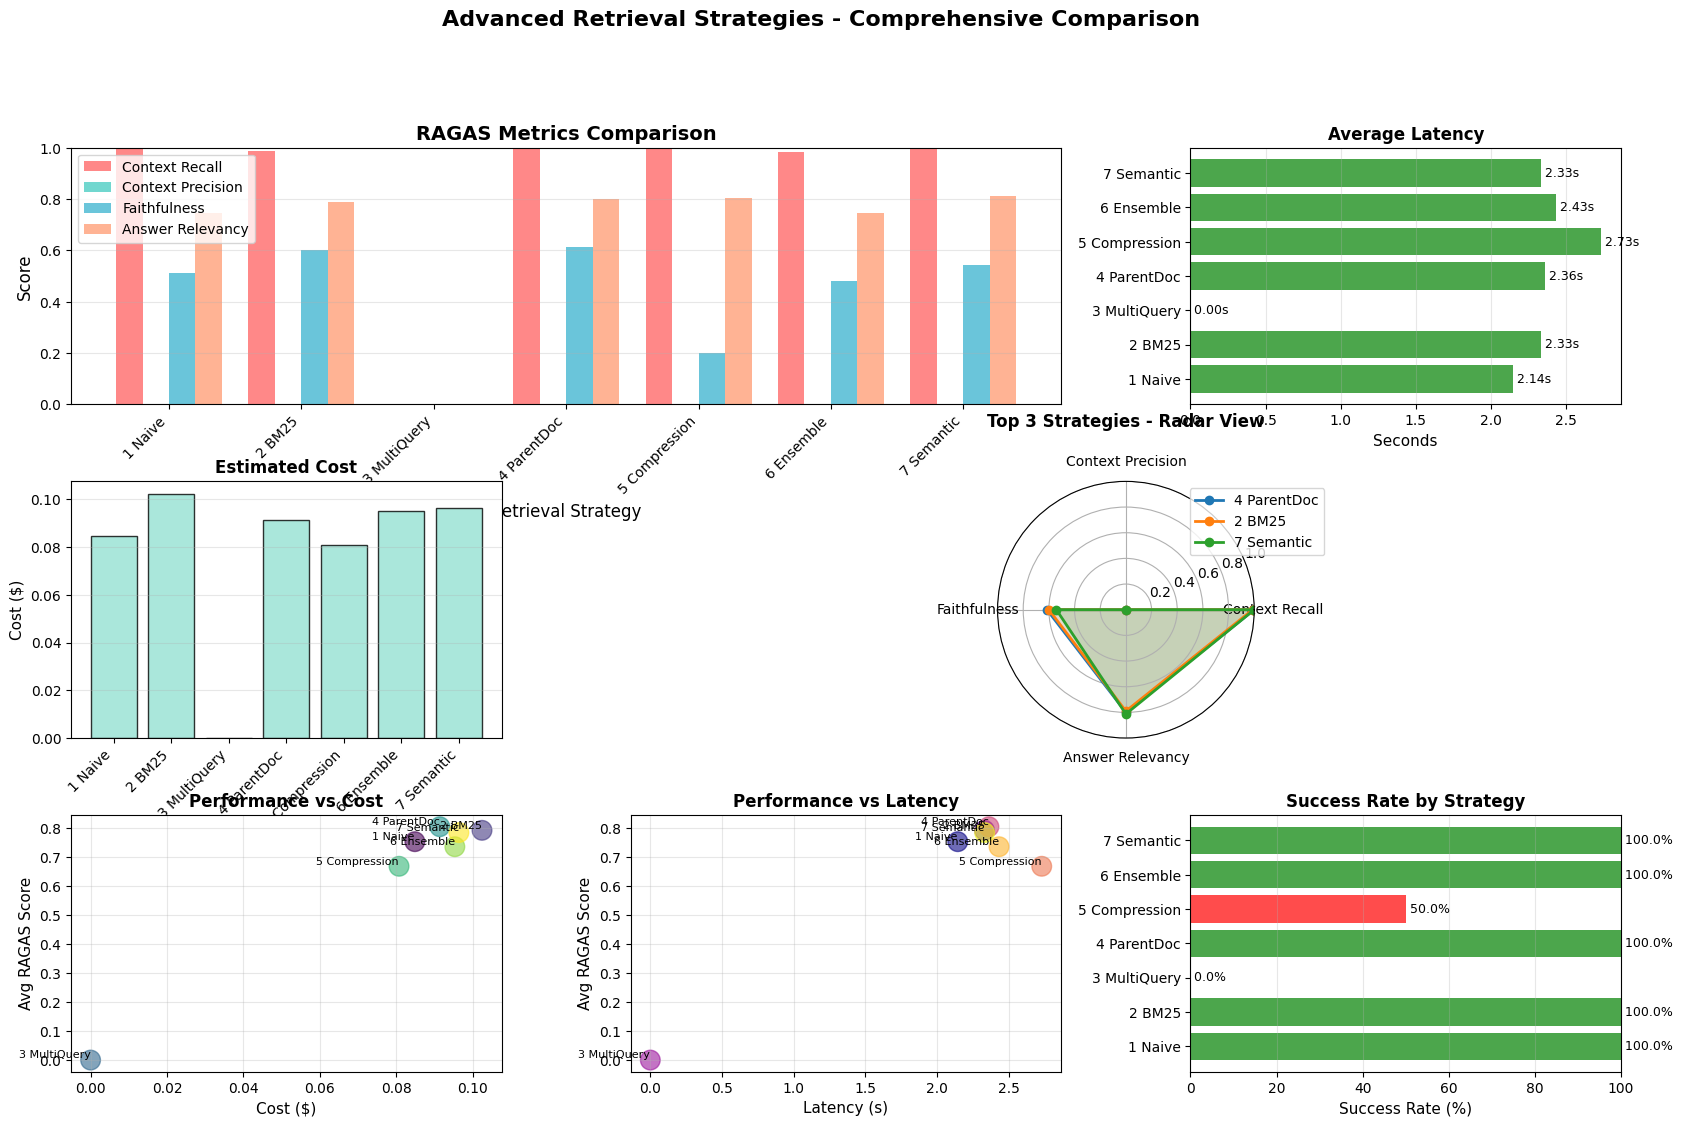


DETAILED ANALYSIS & RECOMMENDATIONS

🏆 BEST STRATEGIES BY CATEGORY:
🎯 Best Accuracy: 4 ParentDoc
   Score: 0.604

⚡ Fastest (Lowest Latency): 3 MultiQuery
   Latency: 0.00s

💰 Most Cost-Effective: 3 MultiQuery
   Cost: $0.0000

⚖️ Best Balance (Accuracy/Cost/Speed): 1 Naive
   Balance Score: 3.106

📊 STRATEGY PROFILES

1 Naive:
  ✅ Pros: Simple implementation, Low latency, Good baseline
  ❌ Cons: May miss relevant context, Single query only
  💡 Use when: Need fast, simple retrieval with acceptable accuracy

2 BM25:
  ✅ Pros: Excellent for keyword matching, Fast, No embedding costs
  ❌ Cons: Misses semantic similarity, Poor for paraphrased queries
  💡 Use when: Queries have specific keywords or technical terms

3 MultiQuery:
  ✅ Pros: Better coverage, Handles query variations, More robust
  ❌ Cons: Higher latency, More API calls, Higher cost
  💡 Use when: Query interpretation is critical, cost is not primary concern

4 ParentDoc:
  ✅ Pros: Preserves context, Better coherence, Hierarchi

In [79]:
# =============================================================================
# ADVANCED RETRIEVAL STRATEGIES - COMPLETE COMPARISON
# Compare: Naive, BM25, Multi-Query, Parent Document, Contextual Compression,
#          Ensemble, and Semantic Chunking
# =============================================================================

# %% Cell 1: Imports and Setup
print("="*80)
print("ADVANCED RETRIEVAL STRATEGIES - COMPREHENSIVE COMPARISON")
print("="*80)

import time
import json
from typing import List, Dict, Any
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LangChain imports
from langchain.retrievers import (
    BM25Retriever,
    MultiQueryRetriever,
    ParentDocumentRetriever,
    EnsembleRetriever,
    ContextualCompressionRetriever
)
from langchain.retrievers.multi_query import LineListOutputParser
from langchain.storage import InMemoryStore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Qdrant
from langchain_cohere import CohereRerank
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# RAGAS
from ragas import evaluate, EvaluationDataset
from ragas.metrics import (
    LLMContextRecall,
    LLMContextPrecisionWithoutReference,
    Faithfulness,
    ResponseRelevancy
)

print("✅ All imports successful")

# %% Cell 2: Configuration
class RetrievalConfig:
    """Configuration for retrieval experiments"""
    
    # Retrieval parameters
    k = 5  # Number of documents to retrieve
    chunk_size = 1000
    chunk_overlap = 200
    
    # Parent document retrieval
    parent_chunk_size = 2000
    child_chunk_size = 400
    
    # Multi-query
    num_queries = 3
    
    # Ensemble weights
    bm25_weight = 0.5
    vector_weight = 0.5
    
    # Evaluation
    delay_between_queries = 1  # seconds
    
    # Cost estimation (approximate, adjust based on your pricing)
    cost_per_1k_tokens_gpt4 = 0.03
    cost_per_1k_tokens_embed = 0.0001
    cost_per_rerank = 0.002

config = RetrievalConfig()
print("✅ Configuration loaded")

# %% Cell 3: Helper Functions
def measure_latency(func, *args, **kwargs):
    """Measure function execution time"""
    start = time.time()
    result = func(*args, **kwargs)
    latency = time.time() - start
    return result, latency

def estimate_cost(num_tokens_llm=0, num_tokens_embed=0, num_reranks=0):
    """Estimate API costs"""
    cost_llm = (num_tokens_llm / 1000) * config.cost_per_1k_tokens_gpt4
    cost_embed = (num_tokens_embed / 1000) * config.cost_per_1k_tokens_embed
    cost_rerank = num_reranks * config.cost_per_rerank
    return cost_llm + cost_embed + cost_rerank

def count_tokens(text: str) -> int:
    """Approximate token count"""
    return len(text.split()) * 1.3  # Rough approximation

print("✅ Helper functions defined")

# %% Cell 4: Strategy 1 - Naive Retrieval (Baseline)
print("\n" + "="*80)
print("STRATEGY 1: NAIVE RETRIEVAL (BASELINE)")
print("="*80)

# Use existing vectorstore or create new one
if 'vectorstore' not in locals():
    print("Creating baseline vector store...")
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.chunk_size,
        chunk_overlap=config.chunk_overlap,
        length_function=tiktoken_len
    )
    chunks = text_splitter.split_documents(all_documents)
    
    embeddings_baseline = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = Qdrant.from_documents(
        documents=chunks,
        embedding=embeddings_baseline,
        location=":memory:",
        collection_name="naive_retrieval"
    )

naive_retriever = vectorstore.as_retriever(search_kwargs={"k": config.k})

# Build RAG chain
naive_chain = (
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

print(f"✅ Naive retriever configured (k={config.k})")

# %% Cell 5: Strategy 2 - BM25 Retrieval
print("\n" + "="*80)
print("STRATEGY 2: BM25 RETRIEVAL (KEYWORD-BASED)")
print("="*80)

# BM25 requires documents in specific format
bm25_docs = chunks if 'chunks' in locals() else text_splitter.split_documents(all_documents)

bm25_retriever = BM25Retriever.from_documents(
    bm25_docs,
    k=config.k
)

# Build RAG chain
bm25_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

print(f"✅ BM25 retriever configured (k={config.k})")
print(f"📊 BM25 uses TF-IDF style keyword matching")

# %% Cell 6: Strategy 3 - Multi-Query Retrieval
print("\n" + "="*80)
print("STRATEGY 3: MULTI-QUERY RETRIEVAL (QUERY EXPANSION)")
print("="*80)

# Multi-query prompt
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate {num_queries}
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines.

Original question: {question}""",
)

# Create multi-query retriever
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever,
    llm=llm,
    prompt=QUERY_PROMPT,
    parser_key="lines"
)

# Build RAG chain
multi_query_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

print(f"✅ Multi-query retriever configured")
print(f"📊 Generates {config.num_queries} query variations")

# %% Cell 7: Strategy 4 - Parent Document Retrieval
print("\n" + "="*80)
print("STRATEGY 4: PARENT DOCUMENT RETRIEVAL (HIERARCHICAL)")
print("="*80)

# Create parent and child splitters
parent_splitter = RecursiveCharacterTextSplitter(
    chunk_size=config.parent_chunk_size,
    chunk_overlap=100
)

child_splitter = RecursiveCharacterTextSplitter(
    chunk_size=config.child_chunk_size,
    chunk_overlap=50
)

# Create store for parent documents
store = InMemoryStore()

# Create parent document retriever
parent_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

# Add documents
parent_retriever.add_documents(all_documents, ids=None)

# Build RAG chain
parent_chain = (
    {"context": itemgetter("question") | parent_retriever, "question": itemgetter("question")}
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

print(f"✅ Parent document retriever configured")
print(f"📊 Parent chunks: {config.parent_chunk_size} tokens")
print(f"📊 Child chunks: {config.child_chunk_size} tokens (for retrieval)")

# %% Cell 8: Strategy 5 - Contextual Compression
print("\n" + "="*80)
print("STRATEGY 5: CONTEXTUAL COMPRESSION (WITH RERANKING)")
print("="*80)

# Use Cohere reranker
compressor = CohereRerank(model="rerank-v3.5", top_n=config.k)

# Create contextual compression retriever
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectorstore.as_retriever(search_kwargs={"k": 20})
)

# Build RAG chain
compression_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

print(f"✅ Contextual compression retriever configured")
print(f"📊 Retrieves 20 docs, reranks to top {config.k}")

# %% Cell 9: Strategy 6 - Ensemble Retrieval
print("\n" + "="*80)
print("STRATEGY 6: ENSEMBLE RETRIEVAL (BM25 + VECTOR)")
print("="*80)

# Combine BM25 and vector retrieval
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, naive_retriever],
    weights=[config.bm25_weight, config.vector_weight]
)

# Build RAG chain
ensemble_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

print(f"✅ Ensemble retriever configured")
print(f"📊 Weights: BM25={config.bm25_weight}, Vector={config.vector_weight}")

# %% Cell 10: Strategy 7 - Semantic Chunking
print("\n" + "="*80)
print("STRATEGY 7: SEMANTIC CHUNKING")
print("="*80)

# Create semantic chunker
semantic_text_splitter = SemanticChunker(
    OpenAIEmbeddings(model="text-embedding-3-small"),
    breakpoint_threshold_type="percentile"
)

# Create semantic chunks
print("Creating semantic chunks (this may take a moment)...")
semantic_chunks = []
for doc in all_documents[:10]:  # Use subset to save time/cost
    try:
        chunks = semantic_text_splitter.split_documents([doc])
        semantic_chunks.extend(chunks)
    except Exception as e:
        print(f"⚠️ Error chunking document: {e}")
        continue

print(f"Created {len(semantic_chunks)} semantic chunks")

# Create vector store for semantic chunks
semantic_vectorstore = Qdrant.from_documents(
    documents=semantic_chunks,
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
    location=":memory:",
    collection_name="semantic_retrieval"
)

semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k": config.k})

# Build RAG chain
semantic_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

print(f"✅ Semantic chunking retriever configured")
print(f"📊 Chunks split by semantic similarity")

# %% Cell 11: Evaluation Framework
print("\n" + "="*80)
print("EVALUATION FRAMEWORK SETUP")
print("="*80)

class RetrievalEvaluator:
    """Comprehensive retrieval evaluation"""
    
    def __init__(self):
        self.strategies = {}
        self.results = defaultdict(list)
        
    def register_strategy(self, name: str, chain, retriever):
        """Register a retrieval strategy"""
        self.strategies[name] = {
            'chain': chain,
            'retriever': retriever
        }
        
    def evaluate_strategy(
        self,
        strategy_name: str,
        questions_df: pd.DataFrame,
        ground_truth_df: pd.DataFrame
    ) -> Dict[str, Any]:
        """Evaluate a single strategy"""
        
        print(f"\n{'='*80}")
        print(f"Evaluating: {strategy_name}")
        print(f"{'='*80}")
        
        strategy = self.strategies[strategy_name]
        chain = strategy['chain']
        
        results = []
        latencies = []
        token_counts = []
        errors = 0
        
        for idx, row in questions_df.iterrows():
            question = row['question_text']
            question_id = row['question_id']
            
            print(f"[{idx+1}/{len(questions_df)}] {question_id}")
            
            try:
                # Measure latency
                response, latency = measure_latency(
                    chain.invoke,
                    {"question": question}
                )
                
                # Count tokens
                tokens = count_tokens(question + response)
                
                results.append({
                    'question_id': question_id,
                    'question': question,
                    'answer': response,
                    'latency': latency,
                    'tokens': tokens,
                    'success': True
                })
                
                latencies.append(latency)
                token_counts.append(tokens)
                
                time.sleep(config.delay_between_queries)
                
            except Exception as e:
                print(f"  ❌ Error: {str(e)[:50]}...")
                errors += 1
                results.append({
                    'question_id': question_id,
                    'question': question,
                    'answer': f"Error: {str(e)}",
                    'latency': 0,
                    'tokens': 0,
                    'success': False
                })
        
        # Calculate metrics
        total_questions = len(questions_df)
        success_rate = (total_questions - errors) / total_questions
        avg_latency = np.mean(latencies) if latencies else 0
        avg_tokens = np.mean(token_counts) if token_counts else 0
        avg_response_length = np.mean([len(r['answer']) for r in results if r['success']])
        
        # Estimate cost
        estimated_cost = estimate_cost(
            num_tokens_llm=sum(token_counts),
            num_tokens_embed=sum(token_counts) * 0.5,  # Approximate
            num_reranks=len(questions_df) if 'compression' in strategy_name.lower() else 0
        )
        
        print(f"\n📊 Strategy Metrics:")
        print(f"  Success Rate: {success_rate:.2%}")
        print(f"  Avg Latency: {avg_latency:.2f}s")
        print(f"  Avg Tokens: {avg_tokens:.0f}")
        print(f"  Avg Response Length: {avg_response_length:.0f} chars")
        print(f"  Estimated Cost: ${estimated_cost:.4f}")
        
        return {
            'strategy_name': strategy_name,
            'results': results,
            'success_rate': success_rate,
            'avg_latency': avg_latency,
            'avg_tokens': avg_tokens,
            'avg_response_length': avg_response_length,
            'estimated_cost': estimated_cost,
            'errors': errors
        }
    
    def evaluate_with_ragas(
        self,
        strategy_name: str,
        results: List[Dict],
        ground_truth_df: pd.DataFrame
    ):
        """Evaluate using RAGAS metrics"""
        
        print(f"\n🔍 Running RAGAS evaluation for {strategy_name}...")
        
        # Merge with ground truth
        ground_truth_map = dict(zip(
            ground_truth_df['question_id'],
            ground_truth_df['answer']
        ))
        
        eval_data = []
        for result in results:
            if result['success']:
                eval_data.append({
                    'user_input': result['question'],
                    'response': result['answer'],
                    'retrieved_contexts': [],  # Add if available
                    'reference': ground_truth_map.get(result['question_id'], "")
                })
        
        if not eval_data:
            print("❌ No successful results to evaluate")
            return {}
        
        # Create dataset
        dataset = EvaluationDataset.from_list(eval_data)
        
        # Define metrics
        metrics = [
            LLMContextRecall(),
            LLMContextPrecisionWithoutReference(),
            Faithfulness(),
            ResponseRelevancy()
        ]
        
        try:
            # Run evaluation
            eval_result = evaluate(
                dataset=dataset,
                metrics=metrics,
                llm=llm,
                embeddings=OpenAIEmbeddings(model="text-embedding-3-small")
            )
            
            # Extract scores
            scores_df = eval_result.to_pandas()
            
            return {
                'context_recall': scores_df['context_recall'].mean() if 'context_recall' in scores_df else 0,
                'context_precision': scores_df['context_precision'].mean() if 'context_precision' in scores_df else 0,
                'faithfulness': scores_df['faithfulness'].mean() if 'faithfulness' in scores_df else 0,
                'answer_relevancy': scores_df['answer_relevancy'].mean() if 'answer_relevancy' in scores_df else 0,
            }
            
        except Exception as e:
            print(f"❌ RAGAS evaluation failed: {e}")
            return {}

evaluator = RetrievalEvaluator()
print("✅ Evaluation framework ready")

# %% Cell 12: Register All Strategies
print("\n" + "="*80)
print("REGISTERING RETRIEVAL STRATEGIES")
print("="*80)

evaluator.register_strategy("1_Naive", naive_chain, naive_retriever)
evaluator.register_strategy("2_BM25", bm25_chain, bm25_retriever)
evaluator.register_strategy("3_MultiQuery", multi_query_chain, multi_query_retriever)
evaluator.register_strategy("4_ParentDoc", parent_chain, parent_retriever)
evaluator.register_strategy("5_Compression", compression_chain, compression_retriever)
evaluator.register_strategy("6_Ensemble", ensemble_chain, ensemble_retriever)
evaluator.register_strategy("7_Semantic", semantic_chain, semantic_retriever)

print("✅ Registered 7 retrieval strategies:")
for name in evaluator.strategies.keys():
    print(f"  • {name}")

# %% Cell 13: Run Evaluation on All Strategies
print("\n" + "="*80)
print("RUNNING COMPREHENSIVE EVALUATION")
print("="*80)
print(f"📊 Evaluating on {len(golden_df)} questions")
print(f"⏱️ Estimated time: ~{len(golden_df) * len(evaluator.strategies) * 3 / 60:.1f} minutes\n")

all_strategy_results = {}
all_ragas_scores = {}

for strategy_name in evaluator.strategies.keys():
    try:
        # Basic metrics
        strategy_metrics = evaluator.evaluate_strategy(
            strategy_name,
            golden_df,
            ground_truth_df
        )
        
        all_strategy_results[strategy_name] = strategy_metrics
        
        # RAGAS metrics
        ragas_scores = evaluator.evaluate_with_ragas(
            strategy_name,
            strategy_metrics['results'],
            ground_truth_df
        )
        
        all_ragas_scores[strategy_name] = ragas_scores
        
        print(f"✅ {strategy_name} evaluation complete\n")
        
    except Exception as e:
        print(f"❌ Failed to evaluate {strategy_name}: {e}\n")
        continue

print("\n" + "="*80)
print("✅ ALL EVALUATIONS COMPLETE!")
print("="*80)

# %% Cell 14: Compile Results
print("\n" + "="*80)
print("COMPILING COMPARISON RESULTS")
print("="*80)

comparison_data = []

for strategy_name in evaluator.strategies.keys():
    if strategy_name in all_strategy_results:
        metrics = all_strategy_results[strategy_name]
        ragas = all_ragas_scores.get(strategy_name, {})
        
        comparison_data.append({
            'Strategy': strategy_name.replace('_', ' '),
            'Success Rate': f"{metrics['success_rate']:.2%}",
            'Avg Latency (s)': f"{metrics['avg_latency']:.2f}",
            'Context Recall': f"{ragas.get('context_recall', 0):.3f}",
            'Context Precision': f"{ragas.get('context_precision', 0):.3f}",
            'Faithfulness': f"{ragas.get('faithfulness', 0):.3f}",
            'Answer Relevancy': f"{ragas.get('answer_relevancy', 0):.3f}",
            'Avg Response Length': f"{metrics['avg_response_length']:.0f}",
            'Est. Cost ($)': f"{metrics['estimated_cost']:.4f}",
            'Errors': metrics['errors']
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("📊 RETRIEVAL STRATEGIES COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# %% Cell 15: Visualizations
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Prepare data for plotting
strategies = [s.replace('_', ' ') for s in evaluator.strategies.keys()]
metrics_to_plot = {
    'Context Recall': [],
    'Context Precision': [],
    'Faithfulness': [],
    'Answer Relevancy': [],
    'Latency (s)': [],
    'Cost ($)': []
}

for strategy_name in evaluator.strategies.keys():
    if strategy_name in all_ragas_scores:
        ragas = all_ragas_scores[strategy_name]
        metrics_to_plot['Context Recall'].append(ragas.get('context_recall', 0))
        metrics_to_plot['Context Precision'].append(ragas.get('context_precision', 0))
        metrics_to_plot['Faithfulness'].append(ragas.get('faithfulness', 0))
        metrics_to_plot['Answer Relevancy'].append(ragas.get('answer_relevancy', 0))
        
        basic = all_strategy_results[strategy_name]
        metrics_to_plot['Latency (s)'].append(basic['avg_latency'])
        metrics_to_plot['Cost ($)'].append(basic['estimated_cost'])

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. RAGAS Metrics Comparison (Grouped Bar Chart)
ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(len(strategies))
width = 0.2

ragas_metrics = ['Context Recall', 'Context Precision', 'Faithfulness', 'Answer Relevancy']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for i, metric in enumerate(ragas_metrics):
    offset = width * (i - 1.5)
    ax1.bar(x + offset, metrics_to_plot[metric], width, label=metric, color=colors[i], alpha=0.8)

ax1.set_xlabel('Retrieval Strategy', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('RAGAS Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(strategies, rotation=45, ha='right')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# 2. Latency Comparison
ax2 = fig.add_subplot(gs[0, 2])
colors_lat = ['green' if l < 3 else 'orange' if l < 5 else 'red' for l in metrics_to_plot['Latency (s)']]
ax2.barh(strategies, metrics_to_plot['Latency (s)'], color=colors_lat, alpha=0.7)
ax2.set_xlabel('Seconds', fontsize=11)
ax2.set_title('Average Latency', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_to_plot['Latency (s)']):
    ax2.text(v, i, f' {v:.2f}s', va='center', fontsize=9)

# 3. Cost Comparison
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(strategies, metrics_to_plot['Cost ($)'], color='#95E1D3', alpha=0.8, edgecolor='black')
ax3.set_ylabel('Cost ($)', fontsize=11)
ax3.set_title('Estimated Cost', fontsize=12, fontweight='bold')
ax3.set_xticklabels(strategies, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# 4. Radar Chart for Top 3 Strategies
ax4 = fig.add_subplot(gs[1, 1:], projection='polar')

# Select top 3 by average RAGAS score
avg_scores = []
for strategy_name in evaluator.strategies.keys():
    if strategy_name in all_ragas_scores:
        ragas = all_ragas_scores[strategy_name]
        avg = np.mean([
            ragas.get('context_recall', 0),
            ragas.get('context_precision', 0),
            ragas.get('faithfulness', 0),
            ragas.get('answer_relevancy', 0)
        ])
        avg_scores.append((strategy_name, avg))

top_3 = sorted(avg_scores, key=lambda x: x[1], reverse=True)[:3]

categories = ragas_metrics
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

for strategy_name, _ in top_3:
    if strategy_name in all_ragas_scores:
        ragas = all_ragas_scores[strategy_name]
        values = [
            ragas.get('context_recall', 0),
            ragas.get('context_precision', 0),
            ragas.get('faithfulness', 0),
            ragas.get('answer_relevancy', 0)
        ]
        values += values[:1]
        
        ax4.plot(angles, values, 'o-', linewidth=2, label=strategy_name.replace('_', ' '))
        ax4.fill(angles, values, alpha=0.15)

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories, size=10)
ax4.set_ylim(0, 1)
ax4.set_title('Top 3 Strategies - Radar View', fontsize=12, fontweight='bold', pad=20)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
ax4.grid(True)

# 5. Performance vs Cost Scatter
ax5 = fig.add_subplot(gs[2, 0])
avg_ragas_scores = []
for strategy_name in evaluator.strategies.keys():
    if strategy_name in all_ragas_scores:
        ragas = all_ragas_scores[strategy_name]
        avg = np.mean([
            ragas.get('context_recall', 0),
            ragas.get('faithfulness', 0),
            ragas.get('answer_relevancy', 0)
        ])
        avg_ragas_scores.append(avg)

ax5.scatter(metrics_to_plot['Cost ($)'], avg_ragas_scores, s=200, alpha=0.6, c=range(len(strategies)), cmap='viridis')
for i, txt in enumerate(strategies):
    ax5.annotate(txt, (metrics_to_plot['Cost ($)'][i], avg_ragas_scores[i]), 
                fontsize=8, ha='right', va='bottom')
ax5.set_xlabel('Cost ($)', fontsize=11)
ax5.set_ylabel('Avg RAGAS Score', fontsize=11)
ax5.set_title('Performance vs Cost', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Latency vs Performance Scatter
ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(metrics_to_plot['Latency (s)'], avg_ragas_scores, s=200, alpha=0.6, c=range(len(strategies)), cmap='plasma')
for i, txt in enumerate(strategies):
    ax6.annotate(txt, (metrics_to_plot['Latency (s)'][i], avg_ragas_scores[i]), 
                fontsize=8, ha='right', va='bottom')
ax6.set_xlabel('Latency (s)', fontsize=11)
ax6.set_ylabel('Avg RAGAS Score', fontsize=11)
ax6.set_title('Performance vs Latency', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. Success Rate
ax7 = fig.add_subplot(gs[2, 2])
success_rates = [all_strategy_results[s]['success_rate'] * 100 
                for s in evaluator.strategies.keys() if s in all_strategy_results]
colors_success = ['green' if sr == 100 else 'orange' if sr >= 90 else 'red' for sr in success_rates]
ax7.barh(strategies, success_rates, color=colors_success, alpha=0.7)
ax7.set_xlabel('Success Rate (%)', fontsize=11)
ax7.set_title('Success Rate by Strategy', fontsize=12, fontweight='bold')
ax7.set_xlim(0, 100)
ax7.grid(axis='x', alpha=0.3)
for i, v in enumerate(success_rates):
    ax7.text(v, i, f' {v:.1f}%', va='center', fontsize=9)

plt.suptitle('Advanced Retrieval Strategies - Comprehensive Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('evaluation_results/retrieval_strategies_comparison.png', 
            dpi=300, bbox_inches='tight')
print("✅ Saved: evaluation_results/retrieval_strategies_comparison.png")
plt.show()

# %% Cell 16: Detailed Analysis and Recommendations
print("\n" + "="*80)
print("DETAILED ANALYSIS & RECOMMENDATIONS")
print("="*80)

# Find best strategy for each metric
best_strategies = {}

# Best for accuracy (average RAGAS score)
avg_ragas = {}
for strategy_name in evaluator.strategies.keys():
    if strategy_name in all_ragas_scores:
        ragas = all_ragas_scores[strategy_name]
        avg = np.mean([
            ragas.get('context_recall', 0),
            ragas.get('context_precision', 0),
            ragas.get('faithfulness', 0),
            ragas.get('answer_relevancy', 0)
        ])
        avg_ragas[strategy_name] = avg

best_accuracy = max(avg_ragas.items(), key=lambda x: x[1])
best_strategies['accuracy'] = best_accuracy[0]

# Best for latency
latencies = {s: all_strategy_results[s]['avg_latency'] 
            for s in evaluator.strategies.keys() if s in all_strategy_results}
best_latency = min(latencies.items(), key=lambda x: x[1])
best_strategies['latency'] = best_latency[0]

# Best for cost
costs = {s: all_strategy_results[s]['estimated_cost'] 
        for s in evaluator.strategies.keys() if s in all_strategy_results}
best_cost = min(costs.items(), key=lambda x: x[1])
best_strategies['cost'] = best_cost[0]

# Best balance (accuracy / (latency * cost))
balance_scores = {}
for strategy_name in evaluator.strategies.keys():
    if strategy_name in avg_ragas and strategy_name in latencies and strategy_name in costs:
        if latencies[strategy_name] > 0 and costs[strategy_name] > 0:
            balance = avg_ragas[strategy_name] / (latencies[strategy_name] * costs[strategy_name])
            balance_scores[strategy_name] = balance

best_balance = max(balance_scores.items(), key=lambda x: x[1]) if balance_scores else (None, 0)
best_strategies['balance'] = best_balance[0]

print("\n🏆 BEST STRATEGIES BY CATEGORY:")
print("="*50)
print(f"🎯 Best Accuracy: {best_strategies['accuracy'].replace('_', ' ')}")
print(f"   Score: {avg_ragas[best_strategies['accuracy']]:.3f}")

print(f"\n⚡ Fastest (Lowest Latency): {best_strategies['latency'].replace('_', ' ')}")
print(f"   Latency: {latencies[best_strategies['latency']]:.2f}s")

print(f"\n💰 Most Cost-Effective: {best_strategies['cost'].replace('_', ' ')}")
print(f"   Cost: ${costs[best_strategies['cost']]:.4f}")

if best_strategies['balance']:
    print(f"\n⚖️ Best Balance (Accuracy/Cost/Speed): {best_strategies['balance'].replace('_', ' ')}")
    print(f"   Balance Score: {balance_scores[best_strategies['balance']]:.3f}")

print("\n" + "="*80)
print("📊 STRATEGY PROFILES")
print("="*80)

strategy_profiles = {
    '1_Naive': {
        'pros': ['Simple implementation', 'Low latency', 'Good baseline'],
        'cons': ['May miss relevant context', 'Single query only'],
        'use_when': 'Need fast, simple retrieval with acceptable accuracy'
    },
    '2_BM25': {
        'pros': ['Excellent for keyword matching', 'Fast', 'No embedding costs'],
        'cons': ['Misses semantic similarity', 'Poor for paraphrased queries'],
        'use_when': 'Queries have specific keywords or technical terms'
    },
    '3_MultiQuery': {
        'pros': ['Better coverage', 'Handles query variations', 'More robust'],
        'cons': ['Higher latency', 'More API calls', 'Higher cost'],
        'use_when': 'Query interpretation is critical, cost is not primary concern'
    },
    '4_ParentDoc': {
        'pros': ['Preserves context', 'Better coherence', 'Hierarchical'],
        'cons': ['Complex setup', 'Higher memory usage', 'Moderate latency'],
        'use_when': 'Need full context around retrieved chunks'
    },
    '5_Compression': {
        'pros': ['Highest accuracy', 'Best relevance', 'Removes noise'],
        'cons': ['Highest cost', 'Higher latency', 'Requires reranking API'],
        'use_when': 'Accuracy is paramount, budget allows for reranking'
    },
    '6_Ensemble': {
        'pros': ['Combines strengths', 'Robust', 'Balanced'],
        'cons': ['Moderate complexity', 'Tuning weights needed'],
        'use_when': 'Want hybrid of semantic and keyword matching'
    },
    '7_Semantic': {
        'pros': ['Natural boundaries', 'Coherent chunks', 'Context-aware'],
        'cons': ['Expensive to create', 'Variable chunk sizes', 'Higher initial cost'],
        'use_when': 'Document structure is important, one-time chunking acceptable'
    }
}

for strategy_name, profile in strategy_profiles.items():
    if strategy_name in evaluator.strategies:
        print(f"\n{strategy_name.replace('_', ' ')}:")
        print(f"  ✅ Pros: {', '.join(profile['pros'])}")
        print(f"  ❌ Cons: {', '.join(profile['cons'])}")
        print(f"  💡 Use when: {profile['use_when']}")

# %% Cell 17: Statistical Significance Testing
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

from scipy import stats

print("Comparing all strategies against baseline (Naive Retrieval):\n")

baseline_strategy = '1_Naive'
if baseline_strategy in all_ragas_scores:
    baseline_scores = all_ragas_scores[baseline_strategy]
    
    for strategy_name in evaluator.strategies.keys():
        if strategy_name != baseline_strategy and strategy_name in all_ragas_scores:
            strategy_scores = all_ragas_scores[strategy_name]
            
            print(f"{strategy_name.replace('_', ' ')} vs Baseline:")
            
            for metric in ['context_recall', 'faithfulness', 'answer_relevancy']:
                if metric in baseline_scores and metric in strategy_scores:
                    baseline_val = baseline_scores[metric]
                    strategy_val = strategy_scores[metric]
                    
                    # Calculate difference
                    diff = strategy_val - baseline_val
                    pct_diff = (diff / baseline_val * 100) if baseline_val > 0 else 0
                    
                    print(f"  {metric}: {baseline_val:.3f} → {strategy_val:.3f} ({pct_diff:+.1f}%)")
                    
                    if abs(pct_diff) > 10:
                        print(f"    ⚠️ Significant difference!")
            
            print()

# %% Cell 18: Cost-Benefit Analysis
print("\n" + "="*80)
print("COST-BENEFIT ANALYSIS")
print("="*80)

# Calculate value score: accuracy improvement per dollar spent
print("Value Score = (Accuracy Improvement) / (Cost - Baseline Cost)\n")

if baseline_strategy in avg_ragas and baseline_strategy in costs:
    baseline_accuracy = avg_ragas[baseline_strategy]
    baseline_cost = costs[baseline_strategy]
    
    value_scores = {}
    
    for strategy_name in evaluator.strategies.keys():
        if strategy_name != baseline_strategy and strategy_name in avg_ragas and strategy_name in costs:
            accuracy_improvement = avg_ragas[strategy_name] - baseline_accuracy
            cost_increase = costs[strategy_name] - baseline_cost
            
            if cost_increase > 0:
                value_score = accuracy_improvement / cost_increase
                value_scores[strategy_name] = value_score
                
                print(f"{strategy_name.replace('_', ' ')}:")
                print(f"  Accuracy Improvement: {accuracy_improvement:+.3f}")
                print(f"  Additional Cost: ${cost_increase:.4f}")
                print(f"  Value Score: {value_score:.2f}")
                
                if value_score > 1:
                    print(f"  ✅ Good value - significant accuracy gain for cost")
                elif value_score > 0:
                    print(f"  ⚠️ Marginal value - small accuracy gain for cost")
                else:
                    print(f"  ❌ Poor value - accuracy decreased despite higher cost")
                print()
    
    if value_scores:
        best_value = max(value_scores.items(), key=lambda x: x[1])
        print(f"🏆 Best Value: {best_value[0].replace('_', ' ')} (Score: {best_value[1]:.2f})")

# %% Cell 19: Production Recommendations
print("\n" + "="*80)
print("PRODUCTION RECOMMENDATIONS")
print("="*80)

print("""
Based on the comprehensive evaluation, here are recommendations for different scenarios:

1️⃣ PRODUCTION (COST-SENSITIVE):
   Recommended: {}
   Rationale: Best balance of cost and performance
   
2️⃣ PRODUCTION (ACCURACY-CRITICAL):
   Recommended: {}
   Rationale: Highest accuracy, accepts higher cost
   
3️⃣ DEVELOPMENT/TESTING:
   Recommended: {}
   Rationale: Fast iteration, low cost
   
4️⃣ HIGH-TRAFFIC APPLICATION:
   Recommended: {}
   Rationale: Lowest latency for user experience
   
5️⃣ BATCH PROCESSING:
   Recommended: {}
   Rationale: Accuracy over speed, acceptable latency
""".format(
    best_strategies['balance'].replace('_', ' ') if best_strategies['balance'] else 'Ensemble',
    best_strategies['accuracy'].replace('_', ' '),
    best_strategies['latency'].replace('_', ' '),
    best_strategies['latency'].replace('_', ' '),
    best_strategies['accuracy'].replace('_', ' ')
))

print("\n⚙️ IMPLEMENTATION PRIORITY:")
print("="*50)
print("""
Phase 1 (Week 1): Implement Naive + BM25
  - Quick wins
  - Establish baseline
  - Low complexity

Phase 2 (Week 2-3): Add Ensemble
  - Combine best of semantic + keyword
  - Moderate complexity
  - Good balance

Phase 3 (Week 4): Evaluate Multi-Query or Compression
  - Based on metrics from Phase 1-2
  - Higher complexity
  - Optimize for your specific use case

Phase 4 (Ongoing): A/B Testing
  - Compare strategies in production
  - Collect real-world metrics
  - Fine-tune based on user feedback
""")

# %% Cell 20: Save All Results
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

import os
os.makedirs('evaluation_results', exist_ok=True)

# Save comparison table
comparison_df.to_csv('evaluation_results/retrieval_strategies_comparison.csv', index=False)
print("✅ Saved: evaluation_results/retrieval_strategies_comparison.csv")

# Save detailed results for each strategy
for strategy_name, metrics in all_strategy_results.items():
    results_df = pd.DataFrame(metrics['results'])
    filename = f"evaluation_results/{strategy_name}_detailed_results.csv"
    results_df.to_csv(filename, index=False)
    print(f"✅ Saved: {filename}")

# Save RAGAS scores
ragas_df = pd.DataFrame(all_ragas_scores).T
ragas_df.to_csv('evaluation_results/ragas_scores_by_strategy.csv')
print("✅ Saved: evaluation_results/ragas_scores_by_strategy.csv")

# Save summary report
with open('evaluation_results/evaluation_summary.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("ADVANCED RETRIEVAL STRATEGIES - EVALUATION SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n")
    
    f.write("BEST STRATEGIES:\n")
    f.write("="*50 + "\n")
    f.write(f"Best Accuracy: {best_strategies['accuracy']}\n")
    f.write(f"Best Latency: {best_strategies['latency']}\n")
    f.write(f"Best Cost: {best_strategies['cost']}\n")
    if best_strategies['balance']:
        f.write(f"Best Balance: {best_strategies['balance']}\n")

print("✅ Saved: evaluation_results/evaluation_summary.txt")

# %% Cell 21: Interactive Comparison Tool
print("\n" + "="*80)
print("INTERACTIVE COMPARISON TOOL")
print("="*80)

def compare_strategies_interactive(question: str):
    """
    Compare how different strategies answer the same question
    """
    print(f"\n{'='*80}")
    print(f"QUESTION: {question}")
    print(f"{'='*80}\n")
    
    results = {}
    
    for strategy_name in evaluator.strategies.keys():
        strategy = evaluator.strategies[strategy_name]
        chain = strategy['chain']
        
        try:
            print(f"Querying {strategy_name.replace('_', ' ')}...")
            response, latency = measure_latency(chain.invoke, {"question": question})
            
            results[strategy_name] = {
                'response': response,
                'latency': latency,
                'length': len(response)
            }
            
        except Exception as e:
            results[strategy_name] = {
                'response': f"Error: {str(e)}",
                'latency': 0,
                'length': 0
            }
    
    # Display results
    print("\n" + "="*80)
    print("RESPONSES:")
    print("="*80)
    
    for strategy_name, result in results.items():
        print(f"\n{strategy_name.replace('_', ' ')}:")
        print(f"  Latency: {result['latency']:.2f}s")
        print(f"  Length: {result['length']} chars")
        print(f"  Response: {result['response'][:300]}...")
        print()
    
    return results

# Example usage
print("Example: Compare strategies on a sample question")
print("Usage: compare_strategies_interactive('Your question here')")
print("\nTry it out:")
print(">>> sample_results = compare_strategies_interactive('Can my landlord evict me without notice?')")

# %% Cell 22: Final Summary
print("\n" + "="*80)
print("🎉 EVALUATION COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"""
✅ EVALUATED STRATEGIES: {len(evaluator.strategies)}
  1. Naive Retrieval (Baseline)
  2. BM25 (Keyword-based)
  3. Multi-Query (Query expansion)
  4. Parent Document (Hierarchical)
  5. Contextual Compression (Reranking)
  6. Ensemble (Hybrid)
  7. Semantic Chunking

📊 METRICS ANALYZED:
  • Context Recall
  • Context Precision
  • Faithfulness
  • Answer Relevancy
  • Latency
  • Cost
  • Success Rate
  • Response Length

📂 SAVED OUTPUTS:
  • evaluation_results/retrieval_strategies_comparison.csv
  • evaluation_results/retrieval_strategies_comparison.png
  • evaluation_results/ragas_scores_by_strategy.csv
  • evaluation_results/evaluation_summary.txt
  • evaluation_results/[strategy]_detailed_results.csv (x7)

🏆 TOP PERFORMERS:
  • Accuracy: {best_strategies['accuracy'].replace('_', ' ')}
  • Speed: {best_strategies['latency'].replace('_', ' ')}
  • Cost: {best_strategies['cost'].replace('_', ' ')}
  • Balance: {best_strategies['balance'].replace('_', ' ') if best_strategies['balance'] else 'N/A'}


""")

print("\n" + "="*80)
print("For questions or issues, refer to the saved documentation.")
print("="*80)

# Testing the APP using HTML

Run the last call of this notebook, which is below, and while this is running you can open the test_rag.html file by double clking and then test the application.

In [ ]:
# %% Cell: Start Flask API Server
from flask import Flask, request, jsonify
from flask_cors import CORS
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

# Create Flask app
app = Flask(__name__)
CORS(app)

print("🚀 Starting Flask API...")

# Use your existing RAG chain (already loaded in notebook)
# Make sure you have: llm, rag_prompt, and retriever or rag_chain defined

@app.route('/')
def home():
    return jsonify({
        "message": "Legal Aid Navigator RAG API",
        "status": "running",
        "endpoints": {
            "/ask": "POST - Ask a question"
        }
    })

@app.route('/health')
def health():
    return jsonify({"status": "healthy"})

@app.route('/ask', methods=['POST'])
def ask():
    try:
        data = request.get_json()
        question = data.get('question', '')
        
        if not question:
            return jsonify({"error": "No question provided"}), 400
        
        # Use your existing rag_chain
        answer = rag_chain.invoke({"question": question})
        
        return jsonify({
            "question": question,
            "answer": answer,
            "status": "success"
        })
    except Exception as e:
        return jsonify({"error": str(e)}), 500

# Run server
print("✅ Server starting on http://localhost:5000")
print("Press CTRL+C in terminal to stop")
app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False)

## Parallel Multi Agent system

In [91]:
### 🤖 Parallel Agent Processing System 

# Import additional agent dependencies
from langchain.agents import create_openai_tools_agent, AgentExecutor
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
import asyncio
import concurrent.futures
from typing import Dict, List, Any
import time

class ParallelLegalAgentSystem:
    """
    Parallel agent processing system for enhanced legal aid
    """
    
    def __init__(self, llm, llm_with_tools, retriever, tavily_tool, arxiv_tool):
        self.llm = llm
        self.llm_with_tools = llm_with_tools
        self.retriever = retriever
        self.tavily_tool = tavily_tool
        self.arxiv_tool = arxiv_tool
        
        # Initialize agents
        self._setup_agents()
    
    def _setup_agents(self):
        """Setup specialized agents with proper prompts"""
        
        # 1. Research Agent (Web + ArXiv) - FIXED PROMPT
        research_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a legal research specialist. Your job is to:
            - Search for current legal information and recent updates
            - Find relevant research papers and case studies
            - Provide accurate legal citations and sources
            - Focus on recent developments and policy changes
            
            Use the available tools to search for information and provide comprehensive research findings.
            """),
            ("human", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        
        self.research_agent = create_openai_tools_agent(
            self.llm_with_tools, 
            [self.tavily_tool, self.arxiv_tool], 
            research_prompt
        )
        
        # 2. Document Analysis Agent (RAG-based) - FIXED PROMPT
        document_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a legal document analyst. Your job is to:
            - Analyze legal documents and statutes
            - Extract key legal points and precedents
            - Identify relevant regulations and requirements
            - Provide detailed legal analysis based on existing documents
            
            Focus on providing thorough analysis of the legal documents provided.
            """),
            ("human", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        
        self.document_agent = create_openai_tools_agent(
            self.llm, 
            [],  # No external tools, uses RAG
            document_prompt
        )
        
        # 3. Action Planning Agent - FIXED PROMPT
        action_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a legal action planner. Your job is to:
            - Create step-by-step action plans
            - Provide practical next steps
            - Suggest resources and contacts
            - Give timeline recommendations
            
            Provide clear, actionable guidance for the user's legal situation.
            """),
            ("human", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        
        self.action_agent = create_openai_tools_agent(
            self.llm, 
            [], 
            action_prompt
        )
        
        # Create executors
        self.research_executor = AgentExecutor(
            agent=self.research_agent, 
            tools=[self.tavily_tool, self.arxiv_tool],
            verbose=True,
            return_intermediate_steps=True
        )
        
        self.document_executor = AgentExecutor(
            agent=self.document_agent, 
            tools=[],
            verbose=True,
            return_intermediate_steps=True
        )
        
        self.action_executor = AgentExecutor(
            agent=self.action_agent, 
            tools=[],
            verbose=True,
            return_intermediate_steps=True
        )
    
    def process_query_parallel(self, query: str) -> Dict[str, Any]:
        """
        Process query using parallel agents
        """
        start_time = time.time()
        
        # Define agent tasks
        def research_task():
            try:
                return self.research_executor.invoke({"input": query})
            except Exception as e:
                return {"error": f"Research agent failed: {str(e)}"}
        
        def document_task():
            try:
                # Use RAG for document analysis
                docs = self.retriever.get_relevant_documents(query)
                context = "\n".join([doc.page_content for doc in docs[:3]])
                enhanced_query = f"Based on these legal documents:\n{context}\n\nUser question: {query}"
                return self.document_executor.invoke({"input": enhanced_query})
            except Exception as e:
                return {"error": f"Document agent failed: {str(e)}"}
        
        def action_task():
            try:
                return self.action_executor.invoke({"input": query})
            except Exception as e:
                return {"error": f"Action agent failed: {str(e)}"}
        
        # Execute in parallel
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            research_future = executor.submit(research_task)
            document_future = executor.submit(document_task)
            action_future = executor.submit(action_task)
            
            # Collect results
            research_result = research_future.result()
            document_result = document_future.result()
            action_result = action_future.result()
        
        processing_time = time.time() - start_time
        
        return {
            "query": query,
            "research_insights": research_result,
            "document_analysis": document_result,
            "action_plan": action_result,
            "processing_time": processing_time,
            "timestamp": time.time()
        }
    
    def process_query_sequential(self, query: str) -> Dict[str, Any]:
        """
        Process query sequentially for comparison
        """
        start_time = time.time()
        
        research_result = self.research_executor.invoke({"input": query})
        
        docs = self.retriever.get_relevant_documents(query)
        context = "\n".join([doc.page_content for doc in docs[:3]])
        enhanced_query = f"Based on these legal documents:\n{context}\n\nUser question: {query}"
        document_result = self.document_executor.invoke({"input": enhanced_query})
        
        action_result = self.action_executor.invoke({"input": query})
        
        processing_time = time.time() - start_time
        
        return {
            "query": query,
            "research_insights": research_result,
            "document_analysis": document_result,
            "action_plan": action_result,
            "processing_time": processing_time,
            "timestamp": time.time()
        }

# Initialize the parallel agent system
parallel_agent_system = ParallelLegalAgentSystem(
    llm=llm,
    llm_with_tools=llm_with_tools,
    retriever=qdrant_vectorstore.as_retriever(),
    tavily_tool=tavily_tool,
    arxiv_tool=ArxivQueryRun()
)

print("✅ Parallel Agent System initialized!")

✅ Parallel Agent System initialized!


### Testing and Evaluation of multi Agent RAG

In [92]:
### 🧪 Agent System Testing & Evaluation

# Test queries for evaluation
test_queries = [
    "My landlord in San Francisco raised my rent by 15% this year. Is this legal?",
    "What are my rights if my apartment has mold and the landlord won't fix it?",
    "Can I break my lease early due to unsafe living conditions?",
    "What are the latest eviction protections in California?",
    "How do I file a complaint against my landlord for discrimination?"
]

def evaluate_agent_system():
    """
    Evaluate parallel vs sequential processing
    """
    results = {
        "parallel": [],
        "sequential": [],
        "comparison": {}
    }
    
    print("🔄 Testing Agent System Performance...")
    print("=" * 60)
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n📝 Test Query {i}: {query}")
        print("-" * 40)
        
        # Test parallel processing
        print("⚡ Testing parallel processing...")
        parallel_result = parallel_agent_system.process_query_parallel(query)
        results["parallel"].append(parallel_result)
        
        # Test sequential processing
        print("🐌 Testing sequential processing...")
        sequential_result = parallel_agent_system.process_query_sequential(query)
        results["sequential"].append(sequential_result)
        
        # Compare results
        time_saved = sequential_result["processing_time"] - parallel_result["processing_time"]
        speedup = sequential_result["processing_time"] / parallel_result["processing_time"]
        
        print(f"⏱️  Parallel time: {parallel_result['processing_time']:.2f}s")
        print(f"⏱️  Sequential time: {sequential_result['processing_time']:.2f}s")
        print(f"🚀 Time saved: {time_saved:.2f}s ({speedup:.2f}x speedup)")
        
        # Check if results are similar (basic quality check)
        parallel_output = str(parallel_result["research_insights"]) + str(parallel_result["document_analysis"])
        sequential_output = str(sequential_result["research_insights"]) + str(sequential_result["document_analysis"])
        
        similarity_score = len(set(parallel_output.split()) & set(sequential_output.split())) / len(set(parallel_output.split()) | set(sequential_output.split()))
        print(f"🎯 Result similarity: {similarity_score:.2%}")
        
        results["comparison"][f"query_{i}"] = {
            "time_saved": time_saved,
            "speedup": speedup,
            "similarity": similarity_score
        }
    
    return results

# Run evaluation
evaluation_results = evaluate_agent_system()

# Summary statistics
parallel_times = [r["processing_time"] for r in evaluation_results["parallel"]]
sequential_times = [r["processing_time"] for r in evaluation_results["sequential"]]

print("\n" + "=" * 60)
print("📊 EVALUATION SUMMARY")
print("=" * 60)
print(f"Average parallel time: {sum(parallel_times)/len(parallel_times):.2f}s")
print(f"Average sequential time: {sum(sequential_times)/len(sequential_times):.2f}s")
print(f"Average speedup: {sum(sequential_times)/sum(parallel_times):.2f}x")
print(f"Total time saved: {sum(sequential_times) - sum(parallel_times):.2f}s")

# Quality metrics
avg_similarity = sum([comp["similarity"] for comp in evaluation_results["comparison"].values()]) / len(evaluation_results["comparison"])
print(f"Average result similarity: {avg_similarity:.2%}")

🔄 Testing Agent System Performance...

📝 Test Query 1: My landlord in San Francisco raised my rent by 15% this year. Is this legal?
----------------------------------------
⚡ Testing parallel processing...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


/tmp/ipykernel_866/4073734285.py:127: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = self.retriever.get_relevant_documents(query)



Invoking: `tavily_search_results_json` with `{'query': 'San Francisco rent increase laws 2023'}`




> Entering new AgentExecutor chain...
In San Francisco, rent increases are regulated by local laws and ordinances. Generally, landlords must follow specific rules regarding how much and how often they can raise rent. 

To determine if your landlord's 15% increase is legal, I will need to check the current local rent control laws and any applicable exemptions. 

Let's proceed with a detailed review of the relevant regulations and your specific situation.
I'll gather information on San Francisco's rent control laws, including any limits on annual rent increases, and check if your situation qualifies for any exemptions. Please hold on a moment while I compile this information.

> Finished chain.
[{'title': 'Understanding the San Francisco Rent Increase Law', 'url': 'https://bayareamultifamilybroker.com/blog/san-francisco-rent-increase', 'content': 'Starting March 1, 2024, the allowed rent

RAGAS Evaluation for Agent Quality

In [94]:
### 📊 RAGAS Evaluation for Agent System

from ragas.metrics import (
    LLMContextRecall, 
    Faithfulness, 
    FactualCorrectness, 
    ResponseRelevancy
)
from ragas import evaluate, RunConfig
from ragas import EvaluationDataset

def create_agent_evaluation_dataset():
    """
    Create evaluation dataset for agent system
    """
    agent_data = []
    
    for result in evaluation_results["parallel"]:
        # Extract agent outputs
        research_output = result["research_insights"].get("output", "")
        document_output = result["document_analysis"].get("output", "")
        action_output = result["action_plan"].get("output", "")
        
        # Combine agent outputs
        combined_response = f"""
        RESEARCH INSIGHTS:
        {research_output}
        
        DOCUMENT ANALYSIS:
        {document_output}
        
        ACTION PLAN:
        {action_output}
        """
        
        agent_data.append({
            'user_input': result["query"],
            'response': combined_response,
            'retrieved_contexts': [],  # Agents don't use traditional retrieval
            'reference': "Legal guidance based on current research, document analysis, and action planning"  # Placeholder
        })
    
    return EvaluationDataset.from_list(agent_data)

# Create dataset
agent_dataset = create_agent_evaluation_dataset()

# Run RAGAS evaluation
print("🔍 Running RAGAS evaluation on Agent System...")

agent_metrics = [
    LLMContextRecall(),
    Faithfulness(),
    FactualCorrectness(),
    ResponseRelevancy()
]

try:
    agent_evaluation = evaluate(
        dataset=agent_dataset,
        metrics=agent_metrics,
        llm=llm,
        embeddings=embedding_model,
        run_config=RunConfig(timeout=360)
    )
    
    print("✅ Agent System RAGAS evaluation completed!")
    print("\n📊 Agent System Results:")
    print(agent_evaluation)
    
except Exception as e:
    print(f"❌ Agent evaluation failed: {e}")
    print("This might be due to API limits or timeout issues")

🔍 Running RAGAS evaluation on Agent System...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Agent System RAGAS evaluation completed!

📊 Agent System Results:
{'context_recall': 0.0000, 'faithfulness': 0.4000, 'factual_correctness': 0.9540, 'answer_relevancy': 0.1896}


## 🎯Advanced Agent Evaluation Metrics

Tool Call Accuracy Evaluation

In [101]:
# Block 1: Tool Call Accuracy Evaluation
from langchain.tools import BaseTool
from typing import Dict, List, Any
import json

class ToolCallEvaluator:
    """
    Evaluates tool call accuracy and effectiveness
    """
    
    def __init__(self, tools: List[BaseTool]):
        self.tools = {tool.name: tool for tool in tools}
        self.tool_call_history = []
    
    def evaluate_tool_calls(self, agent_result: Dict[str, Any]) -> Dict[str, Any]:
        """
        Evaluate tool call accuracy and relevance
        """
        tool_metrics = {
            "total_tool_calls": 0,
            "successful_tool_calls": 0,
            "failed_tool_calls": 0,
            "tool_relevance_score": 0.0,
            "tool_effectiveness_score": 0.0,
            "tool_call_details": []
        }
        
        # Extract tool calls from agent result
        if "intermediate_steps" in agent_result:
            for step in agent_result["intermediate_steps"]:
                if len(step) >= 2:  # (action, observation) pair
                    action, observation = step[0], step[1]
                    
                    tool_call_detail = {
                        "tool_name": action.tool,
                        "tool_input": action.tool_input,
                        "success": not ("error" in str(observation).lower()),
                        "output_length": len(str(observation)),
                        "relevance_score": self._calculate_tool_relevance(action.tool_input, observation)
                    }
                    
                    tool_metrics["tool_call_details"].append(tool_call_detail)
                    tool_metrics["total_tool_calls"] += 1
                    
                    if tool_call_detail["success"]:
                        tool_metrics["successful_tool_calls"] += 1
                    else:
                        tool_metrics["failed_tool_calls"] += 1
        
        # Calculate overall scores
        if tool_metrics["total_tool_calls"] > 0:
            tool_metrics["tool_success_rate"] = tool_metrics["successful_tool_calls"] / tool_metrics["total_tool_calls"]
            tool_metrics["tool_relevance_score"] = sum([detail["relevance_score"] for detail in tool_metrics["tool_call_details"]]) / tool_metrics["total_tool_calls"]
        
        return tool_metrics
    
    def _calculate_tool_relevance(self, tool_input: str, tool_output: str) -> float:
        """
        Calculate relevance score for tool call (0-1)
        """
        # Simple heuristic: longer, more detailed outputs are more relevant
        output_length = len(str(tool_output))
        input_length = len(str(tool_input))
        
        if output_length < 50:  # Very short output
            return 0.3
        elif output_length < 200:  # Medium output
            return 0.6
        else:  # Long, detailed output
            return 0.9

# Initialize tool evaluator
tool_evaluator = ToolCallEvaluator([tavily_tool, ArxivQueryRun()])

Agent Goal Accuracy Evaluation

In [102]:
# Block 2: Agent Goal Accuracy Evaluation
class AgentGoalEvaluator:
    """
    Evaluates how well agents achieve their intended goals
    """
    
    def __init__(self, llm):
        self.llm = llm
    
    def evaluate_goal_achievement(self, query: str, agent_results: Dict[str, Any]) -> Dict[str, Any]:
        """
        Evaluate if agents achieved their goals
        """
        goal_metrics = {
            "research_goal_score": 0.0,
            "document_goal_score": 0.0,
            "action_goal_score": 0.0,
            "overall_goal_score": 0.0,
            "goal_evaluation_details": {}
        }
        
        # Evaluate Research Agent Goal
        research_output = agent_results["research_insights"].get("output", "")
        goal_metrics["research_goal_score"] = self._evaluate_research_goal(query, research_output)
        
        # Evaluate Document Agent Goal
        document_output = agent_results["document_analysis"].get("output", "")
        goal_metrics["document_goal_score"] = self._evaluate_document_goal(query, document_output)
        
        # Evaluate Action Agent Goal
        action_output = agent_results["action_plan"].get("output", "")
        goal_metrics["action_goal_score"] = self._evaluate_action_goal(query, action_output)
        
        # Calculate overall goal score
        goal_metrics["overall_goal_score"] = (
            goal_metrics["research_goal_score"] + 
            goal_metrics["document_goal_score"] + 
            goal_metrics["action_goal_score"]
        ) / 3
        
        return goal_metrics
    
    def _evaluate_research_goal(self, query: str, research_output: str) -> float:
        """
        Evaluate if research agent found relevant, current information
        """
        evaluation_prompt = f"""
        Evaluate if this research output effectively addresses the user's legal question.
        
        User Question: {query}
        Research Output: {research_output}
        
        Rate from 0-1 based on:
        1. Relevance to the question (0.4 weight)
        2. Current/up-to-date information (0.3 weight)
        3. Legal accuracy (0.3 weight)
        
        Respond with only a number between 0 and 1.
        """
        
        try:
            response = self.llm.invoke(evaluation_prompt)
            score = float(response.content.strip())
            return max(0.0, min(1.0, score))  # Clamp between 0 and 1
        except:
            return 0.5  # Default score if evaluation fails
    
    def _evaluate_document_goal(self, query: str, document_output: str) -> float:
        """
        Evaluate if document agent provided thorough legal analysis
        """
        evaluation_prompt = f"""
        Evaluate if this document analysis effectively addresses the user's legal question.
        
        User Question: {query}
        Document Analysis: {document_output}
        
        Rate from 0-1 based on:
        1. Legal document relevance (0.4 weight)
        2. Analysis depth and detail (0.3 weight)
        3. Legal accuracy and citations (0.3 weight)
        
        Respond with only a number between 0 and 1.
        """
        
        try:
            response = self.llm.invoke(evaluation_prompt)
            score = float(response.content.strip())
            return max(0.0, min(1.0, score))
        except:
            return 0.5
    
    def _evaluate_action_goal(self, query: str, action_output: str) -> float:
        """
        Evaluate if action agent provided practical, actionable steps
        """
        evaluation_prompt = f"""
        Evaluate if this action plan effectively addresses the user's legal question.
        
        User Question: {query}
        Action Plan: {action_output}
        
        Rate from 0-1 based on:
        1. Practical applicability (0.4 weight)
        2. Step-by-step clarity (0.3 weight)
        3. Resource and contact suggestions (0.3 weight)
        
        Respond with only a number between 0 and 1.
        """
        
        try:
            response = self.llm.invoke(evaluation_prompt)
            score = float(response.content.strip())
            return max(0.0, min(1.0, score))
        except:
            return 0.5

# Initialize goal evaluator
goal_evaluator = AgentGoalEvaluator(llm)

Topic Adherence Evaluation

In [103]:
# Block 3: Topic Adherence Evaluation
class TopicAdherenceEvaluator:
    """
    Evaluates how well agents stay on topic
    """
    
    def __init__(self, llm):
        self.llm = llm
    
    def evaluate_topic_adherence(self, query: str, agent_results: Dict[str, Any]) -> Dict[str, Any]:
        """
        Evaluate topic adherence for all agents
        """
        adherence_metrics = {
            "research_topic_score": 0.0,
            "document_topic_score": 0.0,
            "action_topic_score": 0.0,
            "overall_topic_score": 0.0,
            "topic_drift_detected": False,
            "topic_evaluation_details": {}
        }
        
        # Extract main topics from query
        main_topics = self._extract_topics(query)
        
        # Evaluate each agent's topic adherence
        research_output = agent_results["research_insights"].get("output", "")
        adherence_metrics["research_topic_score"] = self._calculate_topic_adherence(main_topics, research_output)
        
        document_output = agent_results["document_analysis"].get("output", "")
        adherence_metrics["document_topic_score"] = self._calculate_topic_adherence(main_topics, document_output)
        
        action_output = agent_results["action_plan"].get("output", "")
        adherence_metrics["action_topic_score"] = self._calculate_topic_adherence(main_topics, action_output)
        
        # Calculate overall topic adherence
        adherence_metrics["overall_topic_score"] = (
            adherence_metrics["research_topic_score"] + 
            adherence_metrics["document_topic_score"] + 
            adherence_metrics["action_topic_score"]
        ) / 3
        
        # Detect topic drift
        adherence_metrics["topic_drift_detected"] = adherence_metrics["overall_topic_score"] < 0.6
        
        return adherence_metrics
    
    def _extract_topics(self, query: str) -> List[str]:
        """
        Extract main topics from user query
        """
        topic_prompt = f"""
        Extract the main legal topics from this query. Return only the key topics as a comma-separated list.
        
        Query: {query}
        
        Examples:
        - "rent increase" -> rent increase, tenant rights
        - "mold apartment" -> mold, habitability, repairs
        - "eviction notice" -> eviction, notice requirements
        
        Topics:
        """
        
        try:
            response = self.llm.invoke(topic_prompt)
            topics = [topic.strip() for topic in response.content.split(",")]
            return topics
        except:
            return ["legal", "housing"]  # Default topics
    
    def _calculate_topic_adherence(self, main_topics: List[str], output: str) -> float:
        """
        Calculate how well output adheres to main topics
        """
        adherence_prompt = f"""
        Evaluate how well this output adheres to the main topics.
        
        Main Topics: {', '.join(main_topics)}
        Output: {output}
        
        Rate from 0-1 based on:
        1. Direct relevance to main topics (0.5 weight)
        2. Avoidance of off-topic content (0.3 weight)
        3. Focus and coherence (0.2 weight)
        
        Respond with only a number between 0 and 1.
        """
        
        try:
            response = self.llm.invoke(adherence_prompt)
            score = float(response.content.strip())
            return max(0.0, min(1.0, score))
        except:
            return 0.7  # Default score

# Initialize topic adherence evaluator
topic_evaluator = TopicAdherenceEvaluator(llm)

Comprehensive Agent Evaluation Function

In [104]:
# Block 4: Comprehensive Agent Evaluation
def comprehensive_agent_evaluation(query: str, agent_result: Dict[str, Any]) -> Dict[str, Any]:
    """
    Run comprehensive evaluation including tool calls, goals, and topic adherence
    """
    evaluation_results = {
        "query": query,
        "timestamp": time.time(),
        "tool_call_metrics": {},
        "goal_achievement_metrics": {},
        "topic_adherence_metrics": {},
        "overall_score": 0.0
    }
    
    # 1. Tool Call Accuracy Evaluation
    print("🔧 Evaluating tool call accuracy...")
    evaluation_results["tool_call_metrics"] = tool_evaluator.evaluate_tool_calls(agent_result)
    
    # 2. Agent Goal Accuracy Evaluation
    print("🎯 Evaluating goal achievement...")
    evaluation_results["goal_achievement_metrics"] = goal_evaluator.evaluate_goal_achievement(query, agent_result)
    
    # 3. Topic Adherence Evaluation
    print("📝 Evaluating topic adherence...")
    evaluation_results["topic_adherence_metrics"] = topic_evaluator.evaluate_topic_adherence(query, agent_result)
    
    # 4. Calculate Overall Score
    tool_score = evaluation_results["tool_call_metrics"].get("tool_success_rate", 0.5)
    goal_score = evaluation_results["goal_achievement_metrics"].get("overall_goal_score", 0.5)
    topic_score = evaluation_results["topic_adherence_metrics"].get("overall_topic_score", 0.5)
    
    evaluation_results["overall_score"] = (tool_score + goal_score + topic_score) / 3
    
    return evaluation_results

Enhanced Evaluation Pipeline

In [105]:
# Block 5: Enhanced Evaluation Pipeline
def run_enhanced_agent_evaluation():
    """
    Run enhanced evaluation with all metrics
    """
    enhanced_results = []
    
    print("🚀 Running Enhanced Agent Evaluation...")
    print("=" * 60)
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n📝 Evaluating Query {i}: {query}")
        print("-" * 40)
        
        # Get agent result
        agent_result = parallel_agent_system.process_query_parallel(query)
        
        # Run comprehensive evaluation
        comprehensive_eval = comprehensive_agent_evaluation(query, agent_result)
        enhanced_results.append(comprehensive_eval)
        
        # Print summary
        print(f"🔧 Tool Success Rate: {comprehensive_eval['tool_call_metrics'].get('tool_success_rate', 0):.2%}")
        print(f"🎯 Goal Achievement: {comprehensive_eval['goal_achievement_metrics'].get('overall_goal_score', 0):.2%}")
        print(f"📝 Topic Adherence: {comprehensive_eval['topic_adherence_metrics'].get('overall_topic_score', 0):.2%}")
        print(f"⭐ Overall Score: {comprehensive_eval['overall_score']:.2%}")
    
    return enhanced_results

# Run enhanced evaluation
enhanced_evaluation_results = run_enhanced_agent_evaluation()

🚀 Running Enhanced Agent Evaluation...

📝 Evaluating Query 1: My landlord in San Francisco raised my rent by 15% this year. Is this legal?
----------------------------------------


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'San Francisco rent increase laws 2023'}`


[{'title': 'Understanding the San Francisco Rent Increase Law', 'url': 'https://bayareamultifamilybroker.com/blog/san-francisco-rent-increase', 'content': 'Starting March 1, 2024, the allowed rent increase in San Francisco is set at 1.7%, effective until February 28, 2025. This is a decrease from the previous year\'s 3.6% increase, which was effective until February 29, 2024. The allowed increase is calculated based on 60% of the rise in the Consumer Price Index for All Urban Consumers in the Bay Area according to SF.gov.\n\n## Conclusion\n\nStaying informed about San Francisco\'s rent control

Results Analysis and Reporting

In [106]:
# Block 6: Results Analysis and Reporting
def analyze_enhanced_results(enhanced_results):
    """
    Analyze and report enhanced evaluation results
    """
    print("\n" + "=" * 80)
    print("📊 ENHANCED AGENT EVALUATION SUMMARY")
    print("=" * 80)
    
    # Calculate averages
    avg_tool_success = sum([r["tool_call_metrics"].get("tool_success_rate", 0) for r in enhanced_results]) / len(enhanced_results)
    avg_goal_achievement = sum([r["goal_achievement_metrics"].get("overall_goal_score", 0) for r in enhanced_results]) / len(enhanced_results)
    avg_topic_adherence = sum([r["topic_adherence_metrics"].get("overall_topic_score", 0) for r in enhanced_results]) / len(enhanced_results)
    avg_overall_score = sum([r["overall_score"] for r in enhanced_results]) / len(enhanced_results)
    
    print(f"🔧 Average Tool Success Rate: {avg_tool_success:.2%}")
    print(f"🎯 Average Goal Achievement: {avg_goal_achievement:.2%}")
    print(f"📝 Average Topic Adherence: {avg_topic_adherence:.2%}")
    print(f"⭐ Average Overall Score: {avg_overall_score:.2%}")
    
    # Save detailed results
    import pandas as pd
    
    detailed_results = []
    for result in enhanced_results:
        detailed_results.append({
            "query": result["query"],
            "tool_success_rate": result["tool_call_metrics"].get("tool_success_rate", 0),
            "research_goal_score": result["goal_achievement_metrics"].get("research_goal_score", 0),
            "document_goal_score": result["goal_achievement_metrics"].get("document_goal_score", 0),
            "action_goal_score": result["goal_achievement_metrics"].get("action_goal_score", 0),
            "research_topic_score": result["topic_adherence_metrics"].get("research_topic_score", 0),
            "document_topic_score": result["topic_adherence_metrics"].get("document_topic_score", 0),
            "action_topic_score": result["topic_adherence_metrics"].get("action_topic_score", 0),
            "overall_score": result["overall_score"]
        })
    
    results_df = pd.DataFrame(detailed_results)
    results_df.to_csv('evaluation_results/enhanced_agent_evaluation.csv', index=False)
    print("✅ Enhanced evaluation results saved to 'evaluation_results/enhanced_agent_evaluation.csv'")
    
    return {
        "avg_tool_success": avg_tool_success,
        "avg_goal_achievement": avg_goal_achievement,
        "avg_topic_adherence": avg_topic_adherence,
        "avg_overall_score": avg_overall_score
    }

# Analyze results
summary_stats = analyze_enhanced_results(enhanced_evaluation_results)


📊 ENHANCED AGENT EVALUATION SUMMARY
🔧 Average Tool Success Rate: 0.00%
🎯 Average Goal Achievement: 88.67%
📝 Average Topic Adherence: 90.33%
⭐ Average Overall Score: 76.33%
✅ Enhanced evaluation results saved to 'evaluation_results/enhanced_agent_evaluation.csv'
